# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***

The goals of this project are the following:

<ul>
<li>Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
<li>Apply a distortion correction to raw images.
<li>Use color transforms, gradients, etc., to create a thresholded binary image.
<li>Apply a perspective transform to rectify binary image (birds-eye view).
<li>Detect lane pixels and fit to find the lane boundary.
<li>Determine the curvature of the lane and vehicle position with respect to center.
<li>Warp the detected lane boundaries back onto the original image.
<li>Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
</ul>

---

## Import Packages

In [15]:
### Importing necessary packages

import numpy as np                  # For handling images
import glob                         # For iterating through multiple image files
import cv2                          # For image manipulation
import matplotlib.pyplot as plt     # For plotting images

# For plotting to display inline within the notebook
%matplotlib inline

print("All package import complete")

All package import complete


## Define Global Variables

In [16]:
### Global variables and constants defined here

detected_lines = []                  # Global variable to hold all detected lines
reset_lanes = True                   # Flag that drives detection of fresh lanes
terrain_type = None                  # Variable that indicates the terrain type
mtx = dist = None                    # Camera caliberation parameters
perspective_M = perspective_Minv = None  # Perspective and inverse perspective
baseline_lane_width = None           # Baseline lane width in px calculated from reference image
cb = np.empty([360,1930,3])          # Holding variable for image concatenation        
c1 = np.empty([360,640,3])           # Holding variable for image concatenation
c2 = np.empty([370,640,3])           # Holding variable for image concatenation

class Line():                        # Objects of this Line class hold details of a detected lines
    def __init__(self):

        self.fresh_lane = None
        self.good_lane = None
        self.continous_bad_lanes = 0
        self.leftx_base = None
        self.rightx_base = None
        self.leftx = None
        self.lefty = None
        self.rightx = None
        self.righty = None
        self.left_fit = None
        self.right_fit = None
        self.left_curverad = None
        self.right_curverad = None
        self.center_offset_m = None
        self.lane_width = None
        self.smooth_leftx_base = 0
        self.smooth_rightx_base = 0
        self.smooth_left_fit = [0,0,0]
        self.smooth_right_fit = [0,0,0]

print("All global variable definition complete")

All global variable definition complete


## Define support functions

The helper functions needed for this project are defined in this section

In [33]:
### Support Functions

""" The helper functions needed to identify lanes are defined in this section """

def showImg(img):
    """ Combines plt.imshow() and plt.show() so that
        grayscale images can be displayed with a single line funtion call"""
    plt.imshow(img)
    plt.show()
    return

def showGrayImg(img):
    """ Combines plt.imshow() and plt.show() so that 
        images can be displayed with a single line funtion call"""
    plt.imshow(img, cmap="gray")
    plt.show()
    return

def undistort(img):
    """ Undistorts a given image using 
        Camera caliberations"""
    return cv2.undistort(img, mtx, dist, None, mtx)

def grayscale(img):
    """Applies the Grayscale transform
       This will return an image with only one color channel"""
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def check_lighting(img):
    """Checks for low luminosity (shadow or cloudy conditions)
       This will return "Good" if good lighting else return "Bad" """

    img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    img_luminosity = img[430:,:,1]
    if np.average(img_luminosity) < 75:
        lighting_condition = "Bad"
    else:
        lighting_condition = "Good"
    print(np.average(img_luminosity))
    
    return lighting_condition

def switch_on_headlights(img):
    """Illuminates lower half of the image by increasing luminosity
       Returns the input image with bottom section illuminated """
  
    illuminated_image = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    illuminated_image = np.int16(illuminated_image)
    illuminated_image[430:,:,1] = np.clip(illuminated_image[430:,:,1] + 50, 0, 255)
    illuminated_image = np.uint8(illuminated_image)
    illuminated_image = cv2.cvtColor(illuminated_image, cv2.COLOR_HLS2RGB)
    
    return illuminated_image

def gradient(gray, orient, sobel_kernel, thresh):
    """ Calculates directional gradient in the required orientation
        Applies threshold"""
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def gradient_mag(gray, sobel_kernel, mag_thresh):
    """ Calculates gradient magnitude
        Applies threshold"""

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt( (sobelx*sobelx) + (sobely*sobely) )
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary

def gradient_dir(gray, sobel_kernel, dir_thresh):
    """ Calculates gradient direction
        Applies threshold"""
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
#    scaled_dir_grad = np.uint8(255*dir_grad/np.max(dir_grad))
    dir_binary = np.zeros_like(dir_grad)
    dir_binary[(dir_grad >= dir_thresh[0]) & (dir_grad <= dir_thresh[1])] = 1
    return dir_binary

def s_select(img, thresh):
    """ 1) Converts image to HLS color space
        2) Apply a threshold to the S channel
        3) Return a binary image of threshold result """
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    img_s = img[:,:,2]

    sbinary = np.zeros_like(img_s)
    sbinary[(img_s > thresh[0]) & (img_s <= thresh[1])] = 1
    return sbinary

def l_select(img, thresh):
    """ 1) Converts image to HLS color space
        2) Apply a threshold to the S channel
        3) Return a binary image of threshold result """
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    img_l = img[:,:,1]

    lbinary = np.zeros_like(img_l)
    lbinary[(img_l > thresh[0]) & (img_l <= thresh[1])] = 1
    return lbinary

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    global terrain_type
    
    if terrain_type == 'h':
        mask_top_y = 470
        mask_bottom_y = 720
        mask_top_left_x = 360
#        mask_top_right_x = 680
        mask_top_right_x = 800
        mask_bottom_right_x = 1190
#        mask_bottom_right_x = 1240
        mask_bottom_left_x = 75
    elif terrain_type == 'c':
        mask_top_y = 470
        mask_bottom_y = 720
        mask_top_left_x = 580
        mask_top_right_x = 750
#        mask_bottom_right_x = 1150
        mask_bottom_right_x = 1125
        mask_bottom_left_x = 180
    else:
        mask_top_y = 440
        mask_bottom_y = 720
        mask_top_left_x = 530
        mask_top_right_x = 740
        mask_bottom_right_x = 1165
        mask_bottom_left_x = 150
        
    
    vertices = np.array([[(mask_top_left_x, mask_top_y), (mask_top_right_x, mask_top_y),  \
                          (mask_bottom_right_x, mask_bottom_y), (mask_bottom_left_x, mask_bottom_y)]],  \
                             dtype=np.int32) # vertices of the masked area

    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

def calculate_curvature(y_eval, fit):
    """Calculates the radius of curvature of a given line"""
    # y_eval : y-value where we want radius of curvature
    # fit : left or right line fit
    return ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) / np.absolute(2*fit[0])

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    return lines

def img_collage(marked_img):
    """ Concatenate images into a single image
        This helps view different perspectives of the image
        at the same time helping with debugging"""
    global c1, c2
    c3 = np.concatenate((c1,c2),0)    
    marked_img = cv2.resize(marked_img,(1280, 720))
    c0 = cv2.copyMakeBorder(marked_img,0,10,0,10,cv2.BORDER_CONSTANT, value=[255,255,0])
    ct = np.concatenate((c0,c3),1)
    c = np.concatenate((ct,cb),0)
    c = cv2.resize(c,(1280, 720))
    return c

def get_black_patches(img):
    """ This function takes in a 3 channel RGB color image
        and identifies the black patches on the road 
        so that they can be removed from the image"""
    
    img_r = img[:,:,0]
    img_g = img[:,:,1]
    img_b = img[:,:,2]

    rbinary = np.zeros_like(img_r)
    gbinary = np.zeros_like(img_g)
    bbinary = np.zeros_like(img_b)
    rbinary[(img_r > 0) & (img_r < 100)] = 1
    gbinary[(img_g > 0) & (img_g < 100)] = 1
    bbinary[(img_b > 0) & (img_b < 100)] = 1

    # Get black patches (R < 100, G < 100, B < 100)
    black_img = np.zeros_like(img_r,dtype=np.int8)
    black_img[((rbinary == 1) & (gbinary == 1) & (bbinary ==1))] = 1
    
    # Expand the black patch by a few pixes to 
    black_patches = np.zeros_like(black_img,dtype=np.int16)
    black_patches = np.copy(black_img)
    
    j = 10
    
    for y in range(470, black_img.shape[0]-j):
        for x in range(50, black_img.shape[1]-j):
            if black_img[y][x] == 1:
                if black_patches[y][x-j] == 0: black_patches[y][x-j] = 1
                if black_patches[y][x+j] == 0: black_patches[y][x+j] = 1
                if black_patches[y-j][x] == 0: black_patches[y-j][x] = 1
                if black_patches[y+j][x] == 0: black_patches[y+j][x] = 1
                    
    showGrayImg(black_img)
    showGrayImg(black_patches)
    return black_patches

## Extract warped binary image of the lanes

This function takes in a 3 channel RGB color image and returns a warped binary image with the lane markings only

In [34]:
### Function to extract a warped binary image of the lanes

""" This function takes in a 3 channel RGB olor image and 
    returns a warped binary image with the lane markings only """

    # Undistort the image
    # Create necessary color channel filters
    # Create necessary sobel filters
    # Create a combined filter that provides the best results
    # Apply mask to pick up lane pixels only
    # Warp the image

def get_binary_warp(image):

    # Undistort the camera image
    image = undistort(image)
    
    lighting_condition = check_lighting(image)
    if lighting_condition == "Bad":
        image = switch_on_headlights(image)

        
    # Get image filtered by S channel
#    s_chn_img = s_select(image, thresh=(100,255))
    s_chn_img = s_select(image, thresh=(100,255))
    
    # Get image filtered by L channel
    l_chn_img = l_select(image, thresh=(50,255))
    
    # Grayscale the image
    gray_img = grayscale(image)
    gray_img[gray_img < 200] = 0
    
    # Get image filtered by sobel x
    sobelx_img = gradient(gray_img, orient='x', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel y
    sobely_img = gradient(gray_img, orient='y', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel magnitude
    sobel_mag = gradient_mag(gray_img, sobel_kernel=3, mag_thresh=(20,100))
    
    # Get image filtered by sobel gradient direction
    sobel_dir = gradient_dir(gray_img, sobel_kernel=31, dir_thresh=(0.7,1.3))
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    #color_binary = np.dstack(( np.zeros_like(sobelx_img), sobelx_img, s_chn_img))
    
    # Combine the two binary thresholds
    combined_img = np.zeros_like(sobelx_img)
    combined_img[((s_chn_img == 1) | ((sobelx_img == 1) & (sobely_img ==1))) & ((l_chn_img == 1))] = 1

    # Pick up pixels that have high S and L channel values.  This will help address shadow conditions
    combined_img2 = np.zeros_like(sobelx_img)
    combined_img2[((s_chn_img == 1) & (l_chn_img == 1))] = 1
    
    # Pick up pixels that have high sobel x and y values.  This will help pick only strong pixels.
    combined_img3 = np.zeros_like(sobelx_img)
    combined_img3[((sobelx_img == 1) & (sobely_img ==1))] = 1

    # Combine the two binary images.  This image :
    # 1. Will capture lanes under shadows as well
    # 2. Will pick up only strong pixels that have high values both in x and y
    combined_img4 = np.zeros_like(sobelx_img)
    combined_img4[((combined_img2 == 1) | (combined_img3 ==1))] = 1
    
    """
    black_patches = np.zeros_like(gray_img, dtype=np.int16)
    black_patches = get_black_patches(image)
    
    cleaned_img = np.zeros_like(gray_img, dtype=np.int16)
    cleaned_img = combined_img4 - black_patches
    cleaned_img = np.clip(cleaned_img, 0, 1)
    cleaned_img = np.uint8(cleaned_img)
    
    showGrayImg(combined_img4)
    showGrayImg(cleaned_img)
    
    
    # Use Hough transform to filter out non-line pixels and horizontal lines
    lines = hough_lines(combined_img4, 2, np.pi/180, 100, 30, 20)
    #creating a blank to draw lines on
    line_image = np.copy(image)*0
    # Iterate over the output "lines" and draw lines on the blank
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope, intercept = np.polyfit([x1, x2], [y1, y2], 1)
            if((slope*slope) > 0.1) & ((slope*slope) < 100):       # Filters out horizontal lines 
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((combined_img4, combined_img4, combined_img4)) 
    # Draw the lines on the edge image
    combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    showImg(combo)
    
    # Use Hough transform to filter out non-line pixels and horizontal lines
    lines = hough_lines(masked_image, 2, np.pi/180, 100, 100, 100)
    #creating a blank to draw lines on
    line_image = np.zeros_like(masked_image)
    # Iterate over the output "lines" and draw lines on the blank
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope, intercept = np.polyfit([x1, x2], [y1, y2], 1)
            if((slope*slope) > 0.1) & ((slope*slope) < 100):       # Filters out horizontal lines 
#           if True:
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
    
    """

    # Apply mask for lane region only to filter out non-lane pixels.
    masked_image = region_of_interest(combined_img) 
    
    # Warp the image to provide a top down perspective view
    warped_image = cv2.warpPerspective(masked_image, perspective_M, gray_img.shape[::-1], flags=cv2.INTER_LINEAR)
#    showGrayImg(warped_image)

    """
    # Plot the images for review
    f = plt.figure(figsize=(30, 18))
    ax1 = plt.subplot(2, 4, 1)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=10)
    ax2 = plt.subplot(2, 4, 2)
    ax2.imshow(s_chn_img, cmap='gray')
    ax2.set_title('S Channel', fontsize=10)
    ax3 = plt.subplot(2, 4, 3)
    ax3.imshow(l_chn_img, cmap='gray')
    ax3.set_title('L Channel', fontsize=10)
    ax4 = plt.subplot(2, 4, 4)
    ax4.imshow(sobelx_img, cmap="gray")
    ax4.set_title('Gradient x', fontsize=10)
    ax5 = plt.subplot(2, 4, 5)
    ax5.imshow(sobely_img, cmap="gray")
    ax5.set_title('Gradient y', fontsize=10)
    ax6 = plt.subplot(2, 4, 6)
    ax6.imshow(combined_img, cmap="gray")
    ax6.set_title('Combined Image', fontsize=10)
    ax7 = plt.subplot(2, 4, 7)
    ax7.imshow(warped_image, cmap="gray")
    ax7.set_title('Warped View', fontsize=10)
    ax8 = plt.subplot(2, 4, 8)
    ax8.imshow(masked_image, cmap="gray")
    ax8.set_title('Masked View', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.5, bottom=0.)
    f.savefig('Inflight_' + str(idx))
    plt.show()
    """
    
    # Combine images to create a collage of different perspectives
    # This makes it easy to debug as many perspective are shown at the same time
    c4 = cv2.resize(combined_img,(640, 360))
    c4 = np.dstack((c4, c4, c4))*255
    c4 = cv2.copyMakeBorder(c4,0,0,0,5,cv2.BORDER_CONSTANT, value=[255,255,0])
    cv2.putText(c4,"Filtered Binary Image", (150,30), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
    if lighting_condition == "Bad":
        cv2.putText(c4,"Head Lights ON", (150,330), cv2.FONT_HERSHEY_COMPLEX_SMALL, 2, (255,255,0))
        drive_log.write("@ " + str(len(detected_lines)) + " - Switched ON headlights\n")
    else:
        cv2.putText(c4,"Head Lights OFF", (150,330), cv2.FONT_HERSHEY_COMPLEX_SMALL, 2, (100,100,100))
#    print("c4 shape = ", c4.shape)
    c5 = cv2.resize(masked_image,(640, 360))
    c5 = np.dstack((c5, c5, c5))*255
    c5 = cv2.copyMakeBorder(c5,0,0,0,5,cv2.BORDER_CONSTANT, value=[255,255,0])
    cv2.putText(c5,"Masked Binary Image", (150,30), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
#    print("c5 shape = ", c5.shape)
    c6 = cv2.resize(warped_image,(640, 360))
    c6 = np.dstack((c6, c6, c6))*255
#    c6 = cv2.copyMakeBorder(c6,0,0,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
    cv2.putText(c6,"Warped", (180,30), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
    cv2.putText(c6,"Image", (180,60), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
#    print("c6 shape = ", c6.shape)
    global cb
    cb = np.concatenate((c4, c5, c6),1)

    return warped_image

## Detect fresh left and right lanes a warped binary image

This function takes in a warped binary image of the lanes and detects the lanes.  This function is used during the start of the pipeline and whenever multiple bad lines are detected continously

In [19]:
### This function will locate a fresh set of lane lines from a given binary warped image
"""  This function called 
     1. During the start of the pipeline to find the lanes
     2. Whenever continous bad lanes are detected - this will help as a reset"""

def find_fresh_lanes(binary_warped):
    
#    print("Inside reset")
    drive_log.write("@ " + str(len(detected_lines)) + " - Inside reset\n")
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
#    plt.plot(histogram)
#    plt.show()
    

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
#    print(leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 20
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Combine images to create a collage of different perspectives
    # This makes it easy to debug as many perspective are shown at the same time
    global c2
    c2 = cv2.resize(out_img,(640, 360))
    c2 = cv2.copyMakeBorder(c2,0,10,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
#    showImg(c2)
 
    # Reset the flag to indicate that fresh detection has been done
    global reset_lanes
    reset_lanes = False
    
#    showImg(out_img)

    return leftx_base, rightx_base, left_lane_inds, right_lane_inds
    

## Perform sanity check on lane lines

This function performs sanity checks on the identified lane lines and decides if they are high confidence detections

In [40]:
### Perform sanity checks.
""" 1. Sanity check the left and right lanes from the current detection.
    2. Sanity check the lanes against previous good values for continuity """

def sanity_check_lanes(l):
    
    good_lane = True
#    print("inside sanity")
    
    while True:

        # Low Pass Filter - Do the left and rigth lanes have enough pixels
        if len(l.leftx) < 10 or len(l.rightx) < 10:
            good_lane = False
#            print("@", len(detected_lines),  " > low pass failure : ", len(l.leftx), len(l.rightx) )
            drive_log.write("@ " + str(len(detected_lines)) + " > low pass failure : " 
                            + str(len(l.leftx)) + " " + str(len(l.rightx)) + "\n")
            break

        # Is the lane width reasonable (around 3.7 m)
        if not(3 < l.lane_width < 4.5):
            good_lane = False
#            print("@", len(detected_lines),  " > lane width failure : ", l.lane_width)
            drive_log.write("@ " + str(len(detected_lines)) + " > lane width failure : " 
                            + str(l.lane_width) + "\n")
            break

        # Are the lane curvatures reasonable
        if l.left_curverad > 30000 or l.right_curverad > 30000:
            good_lane = False
#            print("@", len(detected_lines),  " > curve check failure : ", l.left_curverad, l.right_curverad)
            drive_log.write("@ " + str(len(detected_lines)) + " > curve check failure : " 
                            + str(l.left_curverad) + " " + str(l.right_curverad) + "\n")
            break

        # Do the left and right lanes have similar curvature
        if abs(l.left_curverad - l.right_curverad) > 20000:
            good_lane = False
#            print("@", len(detected_lines),  " > left and right curves similarity failure : ", l.left_curverad, l.right_curverad)
            drive_log.write("@ " + str(len(detected_lines)) + " > left and right curves similarity failure :" 
                            + str(l.left_curverad) + " " + str(l.right_curverad) + "\n")
            break
            
        # Are the lanes parallel (co-eff check)
#        if abs(l.left_fit[0] - l.right_fit[0]) > 0.0008:
        if abs(l.left_fit[0] - l.right_fit[0]) > 0.0025:
            good_lane = False
#            print("@", len(detected_lines),  " > 2nd order coefficient similarity failure : ", l.left_fit[0], l.right_fit[0])
            drive_log.write("@ " + str(len(detected_lines)) + " > 2nd order coefficient similarity failure :" 
                            + str(l.left_fit[0]) + " " + str(l.right_fit[0]) + "\n")
            break
            
        if abs(l.left_fit[1] - l.right_fit[1]) > 1.3:
            good_lane = False
#            print("@", len(detected_lines),  " > 1st order coefficient similarity failure : ", l.left_fit[1], l.right_fit[1])
            drive_log.write("@ " + str(len(detected_lines)) + " > 1st order coefficient similarity failure :" 
                            + str(l.left_fit[1]) + " " + str(l.right_fit[1]) + "\n")
            break
        
        if not l.fresh_lane:
            
            # Is the lane offset marginal from prev frame
                if abs(l.center_offset_m - detected_lines[-1].center_offset_m) > 0.5:
                    good_lane = False
#                    print("@", len(detected_lines),  " > Continuity check failed - lane offset variation high : ", 
#                          l.center_offset_m, detected_lines[-1].center_offset_m)
                    drive_log.write("@ " + str(len(detected_lines)) + " > Continuity check failed - lane offset variation high : " 
                                    + str(l.center_offset_m) + " " + str(detected_lines[-1].center_offset_m) + "\n")
                    break

            # Is the left curvature offset reasonable from prev frame
#                if abs(l.left_curverad - detected_lines[-1].left_curverad) > abs(3.0 * l.left_curverad):
                if 4.0 < (l.left_curverad / detected_lines[-1].left_curverad) < 0.25:
                    good_lane = False
#                    print("@", len(detected_lines),  " > Continuity check failed - left curve variation high : ", 
#                          l.left_curverad, detected_lines[-1].left_curverad)
                    drive_log.write("@ " + str(len(detected_lines)) + 
                                    " > Continuity check failed - left curve variation high : " 
                                    + str(l.left_curverad) + " " + str(detected_lines[-1].left_curverad) + "\n")
                    break
            
            # Is the right curvature offset reasonable from prev frame
#                if abs(l.right_curverad - detected_lines[-1].right_curverad) > abs(3.0 * l.right_curverad):
                if 4.0 < (l.right_curverad / detected_lines[-1].right_curverad) < 0.25:
                    good_lane = False
#                    print("@", len(detected_lines),  " > Continuity check failed - right curve variation high : ", 
#                          l.right_curverad, detected_lines[-1].right_curverad)
                    drive_log.write("@ " + str(len(detected_lines)) + 
                                    " > Continuity check failed - right curve variation high : " 
                                    + str(l.right_curverad) + " " + str(detected_lines[-1].right_curverad) + "\n")
                    break

            # Is the co-eff offset reasonable from prev frame
            
        break
            
#    print("lane quality = ", good_lane)
    return good_lane

## Extract left and right lane fits from a warped binary image

This function takes in a warped binary image of the lanes and returns the left and right lane fits

In [21]:
### Function to extract the left and right line fits from a given warped binary image of the lanes

""" This function takes in a warped binary image of the lanes and 
    returns the left and right lane fits """

def get_line_fits(binary_warped):
    
#    print("inside get line fit")
    
#    showGrayImg(binary_warped)
    global reset_lanes
#    print('reset status', reset_lanes)

    # Identify indices of non-zero pixels from the binary image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Create a new Line object to store the lane parameters
    l = Line()
    
    if reset_lanes :
        # Fresh lanes being built
        leftx_base, rightx_base, left_lane_inds, right_lane_inds = find_fresh_lanes(binary_warped)
        l.fresh_lane = True
    else:
        # Using coeff from last good detection for plotting new lanes
        l.fresh_lane = False
        margin = 100
        left_fit = detected_lines[-1].left_fit
        right_fit = detected_lines[-1].right_fit
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
        y_base = binary_warped.shape[0]
        leftx_base = left_fit[0]*(y_base**2) + left_fit[1]*y_base + left_fit[2]
        rightx_base = right_fit[0]*(y_base**2) + right_fit[1]*y_base + right_fit[2]
#        print(leftx_base, rightx_base)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#    showImg(out_img)

    # Fit a second order polynomial to each lane
    if len(leftx) == 0 or len(lefty) == 0:
        leftx = detected_lines[-1].leftx
        lefty = detected_lines[-1].lefty
    if len(rightx) == 0 or len(righty) == 0:
        rightx = detected_lines[-1].rightx
        righty = detected_lines[-1].righty

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
#    print("left fit =" , left_fit)
#    print("right fit =" , right_fit)


    # Calculate radius of curvature
    global baseline_lane_width
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty) / 2  # y-value where we want radius of curvature
    ym_per_pix = 30/720 # meters per pixel in y dimension  -->  Manual observation
    xm_per_pix = 3.7/baseline_lane_width # meters per pixel in x dimension
#    xm_per_pix = 3.7/700 # meters per pixel in x dimension
#    ym_per_pix = 3/7 # meters per pixel in y dimension  -->  Manual observation


    # Calculate curvature in pixels
    left_curverad = calculate_curvature(y_eval, left_fit)
    right_curverad = calculate_curvature(y_eval, right_fit)
#    print("Curvature left = ", left_curverad, "px  right = ", right_curverad, "px")
    
    # Fit new polynomials to x,y in world space to calculate curvature in meters
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
     
    # Determine lane width and offset
    lane_width = (rightx_base - leftx_base) * xm_per_pix
    lane_center = int(leftx_base + ((rightx_base - leftx_base) / 2))
    img_center = np.int(binary_warped.shape[1]/2)
    center_offset_px = img_center - lane_center
    center_offset_m = round((center_offset_px * xm_per_pix), 2)

    # Store detect lane parametes in the line object
    l.leftx_base = leftx_base
    l.rightx_base = rightx_base
    l.leftx = leftx
    l.lefty = lefty
    l.rightx = rightx
    l.righty = righty
    l.left_fit = left_fit
    l.right_fit = right_fit
    l.left_curverad = left_curverad
    l.right_curverad = right_curverad
    l.center_offset_m = center_offset_m
    l.lane_width = lane_width
    l.smooth_left_fit = left_fit[:]
    l.smooth_right_fit = right_fit[:]

    # Sanity check the identified lanes.
    if len(detected_lines) == 0:
        # Handle first clip of the pipeline
#        print("inside first frame")
        l.good_lane = True
        l.continous_bad_lanes = 0
    else:
        l.continous_bad_lanes = detected_lines[-1].continous_bad_lanes
        l.good_lane = sanity_check_lanes(l)        

    # Create an image section that will show lane parameters
    # This makes it easy to debug
    global c1
    c1 = np.zeros_like(out_img)
    c1 = cv2.resize(c1,(640, 360))
    c1.fill(255)

    cv2.putText(c1,"Frame Metrics - " + str(len(detected_lines)), (200,30), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lx_base = " + str(int(leftx_base)), (10,60), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rx_base = " + str(int(rightx_base)), (10,90), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"ln_width = " + str(round(lane_width,2)), (10,120), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit2 = " + str(round(left_fit[2],2)), (10,150), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit2 = " + str(round(right_fit[2],2)), (10,180), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit1 = " + str(round(left_fit[1],3)), (10,210), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit1 = " + str(round(right_fit[1],3)), (10,240), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit0 = " + str(round(left_fit[0],6)), (10,270), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit0 = " + str(round(right_fit[0],6)), (10,300), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Fresh Lane = " + str(l.fresh_lane), (295,60), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Good Lane = " + str(l.good_lane), (285,90), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Bad Lns = " + str(l.continous_bad_lanes), (285,120), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Left Curve = " + str(int(l.left_curverad)), (285,150), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Right Curve = " + str(int(l.right_curverad)), (285,180), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
#    c1 = cv2.copyMakeBorder(c1,0,0,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
#    print("c1 =", c1.shape)
#    showImg(c1)

    # If the current lane detection is bad, use the previous good values to draw current lane
    if l.good_lane:
        l.continous_bad_lanes = 0
        i = 1
        # Smoothen the fit over the last n good detections
        for line in detected_lines[::-1]:
            l.smooth_left_fit = l.smooth_left_fit + line.left_fit
            l.smooth_right_fit = l.smooth_right_fit + line.right_fit
            i += 1
            if i >= 5:
                 break 
        l.smooth_left_fit = (l.smooth_left_fit) / i
        l.smooth_right_fit = (l.smooth_right_fit) / i
    else:
        l.continous_bad_lanes += 1
        if l.continous_bad_lanes > 3: 
            global reset_lanes
            reset_lanes = True
        l.leftx_base = detected_lines[-1].leftx_base
        l.rightx_base = detected_lines[-1].rightx_base
        l.leftx = detected_lines[-1].leftx
        l.lefty = detected_lines[-1].lefty
        l.rightx = detected_lines[-1].rightx
        l.righty = detected_lines[-1].righty
        l.left_fit = detected_lines[-1].left_fit
        l.right_fit = detected_lines[-1].right_fit
        l.left_curverad = detected_lines[-1].left_curverad
        l.right_curverad = detected_lines[-1].right_curverad
        l.center_offset_m = detected_lines[-1].center_offset_m
        l.lane_width = detected_lines[-1].lane_width
        l.smooth_left_fit = detected_lines[-1].smooth_left_fit
        l.smooth_right_fit = detected_lines[-1].smooth_right_fit
    
    # Add the current lane lines to the detected_lines list
    detected_lines.append(l)

    return l

<ipython-input-21-4e49bcc47b15>:163: SyntaxWarning: name 'reset_lanes' is used prior to global declaration
  global reset_lanes


## Lane Marker Pipeline

This function acts as a pipeline that takes a 3 channel RGB color image as input and returns the same image with lanes marked in it.


In [22]:
### Lane Marker Pipeline
""" This function acts as a pipeline that takes a 3 channel RGB color image as input
    and returns the same image with lanes marked in it """

def lane_marker_pipeline(image):

    # Get the binary warped image of the input image
    binary_warped = get_binary_warp(image)
    
    # Identify the left and right fits from the binary warped image
    l = get_line_fits(binary_warped)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = l.smooth_left_fit[0]*ploty**2 + l.smooth_left_fit[1]*ploty + l.smooth_left_fit[2]
    right_fitx = l.smooth_right_fit[0]*ploty**2 + l.smooth_right_fit[1]*ploty + l.smooth_right_fit[2]
#    left_fitx = l.left_fit[0]*ploty**2 + l.left_fit[1]*ploty + l.left_fit[2]
#    right_fitx = l.right_fit[0]*ploty**2 + l.right_fit[1]*ploty + l.right_fit[2]

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    line_width = 15
 
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - line_width, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + line_width, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - line_width, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + line_width, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,0, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0, 255))
    result = cv2.addWeighted(out_img, 0.5, window_img, 1.0, 0)

    
    """
    # Draw images
    f = plt.figure(figsize=(30, 18))
   
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(binary_warped, cmap='gray')
    ax1.set_title('Input Image', fontsize=10)
    
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(out_img, cmap='gray')
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')
    ax2.set_title('Marked Image', fontsize=10)
    
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(result, cmap='gray')
    ax3.set_title('Final', fontsize=10)
    ax3.plot(left_fitx, ploty, color='yellow', linewidth=2)
    ax3.plot(right_fitx, ploty, color='yellow', linewidth=2)

    plt.subplots_adjust(left=0., right=1, top=0.5, bottom=0.)
    """

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
#    ax3.plot(left_fitx, ploty, color='yellow', linewidth=2)
#    ax3.plot(right_fitx, ploty, color='yellow', linewidth=2)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
#    showImg(color_warp)
    color_warp = cv2.addWeighted(color_warp, .5, window_img, .5, 0)
#    showImg(color_warp)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, perspective_Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    marked_img = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    curverad = int((l.left_curverad + l.right_curverad) / 2)
    cv2.putText(marked_img,"Radius of Curvature = " + str(curverad) + "m", (50,50), cv2.FONT_HERSHEY_PLAIN, 2.5, (255,255,255))
    if l.center_offset_m > 0:
        offset_txt = "Vehicle is " + str(abs(l.center_offset_m)) + "m right of centre"
    elif l.center_offset_m < 0:
        offset_txt = "Vehicle is " + str(abs(l.center_offset_m)) + "m left of centre"
    else:
        offset_txt = "Vehicle is at centre"
    
    cv2.putText(marked_img,offset_txt, (50,100), cv2.FONT_HERSHEY_PLAIN, 2.5, (255,255,255))
    
    
    return marked_img

## Caliberate Camera
This section caliberates the camera by using chessboard images so that images can be undistorted

In [23]:
### Caliberate Camera

"""This section caliberates the camera by using chessboard images so that images can be undistorted"""

def caliberate_camera():
    # Chessboard corners
    nx = 9
    ny = 6

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/cal*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = grayscale(img)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)

    # Get chessboard image size
    img = cv2.imread('camera_cal/calibration1.jpg')
    img_size = (img.shape[1], img.shape[0])
#    print("Chess board shape = ", img_size)

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    print("Camera caliberated.  mtx = ", mtx, " dist = ", dist)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('camera_cal/test_undist.jpg',dst)

    # Visualize undistortion
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=20)
    plt.show()
    """
    return mtx, dist

## Compute Perspective Transform
This section calculates the Perspective Transform (M) that can be applied to any image later

In [24]:
### Compute Perspective Transform (M) and Inverse Transform (Minv)

""" This function calculates the Perspective Transform (M) that can be applied to any images later """

def compute_perspective():
    
    global terrain_type
    
    if terrain_type == 'h':
        reference_image = 'test_images/h1.png'
    elif terrain_type == 'c':
        reference_image = 'test_images/c1.png'
    else:
        reference_image = 'test_images/straight_lines1.jpg'

    # Read in an image with straight lanes
    img = cv2.imread(reference_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_size = (img.shape[1], img.shape[0])

    #Convert to gray scale
    gray = grayscale(img)

    # Undistorting using mtx and dist from camera caliberation
    dst = undistort(img)
   
    #Set source and destination image co-ordinates
    xoffset = 400 # offset for dst points
    yoffset = 10 # offset for dst points

    #Define 4 source points src = np.float32([[,],[,],[,],[,]]) from the straight lane image
    
    if terrain_type == 'h':
        #src = np.float32([[510,498],[703,498],[961,683],[267,683]]) # Good for harder challenge
        src = np.float32([[513,483],[664,483],[961,683],[267,683]]) # Best for harder challenge
    elif terrain_type == 'c':
        src = np.float32([[629,483],[736,483],[1036,680],[353,680]]) # Best for challenge
        #src = np.float32([[608,500],[741,500],[984,650],[397,650]]) # Good for challenge
    else:
#        src = np.float32([[588,455],[694,455],[998,650],[305,650]]) # Best co-ordinates for normal video
        src = np.float32([[599,448],[682,448],[1010,658],[295,658]]) # second best for p1

    # Define 4 destination points dst = np.float32([[,],[,],[,],[,]]) through trial and error
    dst = np.float32([[xoffset, yoffset], [img_size[0]-xoffset, yoffset], 
                                     [img_size[0]-xoffset, img_size[1]-yoffset], 
                                     [xoffset, img_size[1]-yoffset]])
    
    # Calculate Perspective Transform
    perspective_M = cv2.getPerspectiveTransform(src, dst)
    
    # Calculate Perspective Inverse Transform
    perspective_Minv = cv2.getPerspectiveTransform(dst, src)
    
    print("Perspective M = ", perspective_M)
    
    # Warp the image using the perspective transform M
    warped_image = cv2.warpPerspective(img, perspective_M, gray.shape[::-1], flags=cv2.INTER_LINEAR)

    """
    # Visualize perspective transform
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(warped_image)
    ax2.set_title('Undistorted and Warped Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    """
    
    warped_image = cv2.cvtColor(warped_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite('img_calib.jpg', warped_image)
    
    return perspective_M, perspective_Minv

## Compute Lane Width

Compute the lane width from a straight lane image in pixels which can be used as a reference for pixel to meters conversion.


In [25]:
### Determine the lane width using a clean image (straight line image).
### This image will be used for calculating the pixel to meter conversion for x axis

def compute_lane_width():

    global terrain_type
    
    if terrain_type == 'h':
        reference_image = 'test_images/h1.png'
    elif terrain_type == 'c':
        reference_image = 'test_images/c1.png'
    else:
        reference_image = 'test_images/straight_lines1.jpg'

    # Read in a baseline image (straight lanes image)
    img = cv2.imread(reference_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    binary_warped = get_binary_warp(img)
#    showGrayImg(binary_warped)

    # Take a histogram of the bottom quarter of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//4:,:], axis=0)
#    print(histogram.shape)
#    plt.plot(histogram)
#    plt.show()

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    baseline_midpoint = np.int(histogram.shape[0]/2)
    baseline_leftx_base = np.argmax(histogram[:baseline_midpoint])
    baseline_rightx_base = np.argmax(histogram[baseline_midpoint:]) + baseline_midpoint
    baseline_lane_width = baseline_rightx_base - baseline_leftx_base
    print("Baseline mid, left, center = ", baseline_midpoint, baseline_leftx_base, baseline_rightx_base)
    print("Baeline Lane width in pixels = ", baseline_lane_width)
    
    return baseline_lane_width

## Explore input image characteristics
Read a sample image to find out its shape and type

shape of image object =  (720, 1280, 3)
type of image object =  <class 'numpy.ndarray'>


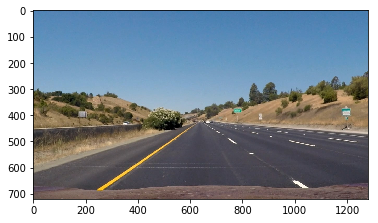

In [26]:
image = cv2.imread("test_images\\straight_lines1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("shape of image object = ", image.shape)
print("type of image object = ", type(image))
showImg(image)   

## Validate pipeline on test images

Use test images to validate the pipeline.


Camera caliberated.  mtx =  [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]  dist =  [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]
Perspective M =  [[ -4.13670072e-01  -1.44474273e+00   8.57970000e+02]
 [ -4.57966998e-15  -2.17056996e+00   1.04708395e+03]
 [ -6.61363325e-18  -2.33982135e-03   1.00000000e+00]]
120.122983462
Baseline mid, left, center =  640 418 906
Baeline Lane width in pixels =  488
106.360600754


C:\Users\ADMIN\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


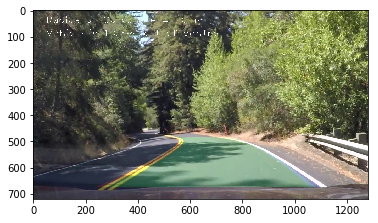

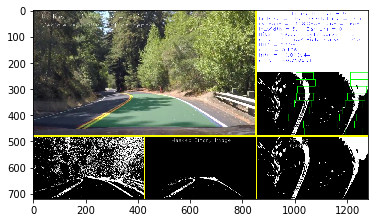

Pair of lanes detected =  1


In [27]:
reset_lanes = True
detected_lines = []

drive_log = open("i_driveLog.txt","w") 
drive_log.write("Driver's Log -------------------\n")

# use n for normal, c for challenge and h for harder
terrain_type = 'h'

# Caliberate Camera
mtx, dist = caliberate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

image = cv2.imread('test_images/h3.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

marked_img = lane_marker_pipeline(image)

showImg(marked_img)
combined_imgs = img_collage(marked_img)
showImg(combined_imgs)
combined_imgs = cv2.cvtColor(combined_imgs, cv2.COLOR_RGB2BGR)
cv2.imwrite('text_test.jpg',combined_imgs)
#drive_log.close()

"""
images = glob.glob('test_images/test1*')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    marked_img = lane_marker_pipeline(image)
    showImg(marked_img)
    combined_imgs = img_collage(marked_img)
    showImg(combined_imgs)
    combined_imgs = cv2.cvtColor(combined_imgs, cv2.COLOR_RGB2BGR)
    cv2.imwrite('text_test.jpg',combined_imgs)
 
"""

print("Pair of lanes detected = ", len(detected_lines))

In [ ]:
marked_img = lane_marker_pipeline(image)
showImg(marked_img)
#drive_log.close()

## Test lane finding pipeline on Videos

This section reads the clips from the video, passes them to the pipeline and creates a video out of the pipeline outputs



In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [29]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # Calling pipeline that will return the final output (image where lines are drawn on lanes)
        
    result = lane_marker_pipeline(image)
    result = img_collage(result)

    return result

## Project Video

Applying lane marking pipeline on project video.

In [ ]:
# Initialize variables
reset_lanes = True
detected_lines = []

drive_log = open("p_driveLog.txt","w") 
drive_log.write("Driver's Log -------------------\n")

# use n for normal, c for challenge and h for harder
terrain_type = 'n'

# Caliberate Camera
mtx, dist = caliberate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

project_video_output = 'project_video_output.mp4'
#clip1 = VideoFileClip("P3.mp4")
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)
print("Number of frames = ", len(detected_lines))
drive_log.close()

## Challenge Video

Applying lane marking pipeline on challenge video.

In [41]:
# Initialize variables
reset_lanes = True
detected_lines = []

drive_log = open("c_driveLog.txt","w") 
drive_log.write("Driver's Log -------------------\n")

# use n for normal, c for challenge and h for harder
terrain_type = 'c'

# Caliberate Camera
mtx, dist = caliberate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

challenge_output = 'challenge_video_output.mp4'
#clip2 = VideoFileClip('challenge_video.mp4')
clip2 = VideoFileClip('c1.mp4')
challenge_video_clip = clip2.fl_image(process_image)
%time challenge_video_clip.write_videofile(challenge_output, audio=False)

drive_log.close()

Camera caliberated.  mtx =  [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]  dist =  [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]
Perspective M =  [[ -3.67753151e-01  -1.41127605e+00   8.80171743e+02]
 [ -5.44009282e-15  -1.92959176e+00   9.31173038e+02]
 [ -8.13151629e-18  -2.24012072e-03   1.00000000e+00]]
112.920051238
Baseline mid, left, center =  640 401 825
Baeline Lane width in pixels =  424
113.598803879
[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


  0%|                                                                                                                                                                                                               | 0/165 [00:00<?, ?it/s]

113.598803879


  1%|█▏                                                                                                                                                                                                     | 1/165 [00:00<00:56,  2.90it/s]

113.797661638


  1%|██▍                                                                                                                                                                                                    | 2/165 [00:00<00:55,  2.91it/s]

113.594622845


  2%|███▌                                                                                                                                                                                                   | 3/165 [00:01<00:55,  2.91it/s]

113.176635237


  2%|████▊                                                                                                                                                                                                  | 4/165 [00:01<00:55,  2.91it/s]

112.992494612


  3%|██████                                                                                                                                                                                                 | 5/165 [00:01<00:54,  2.93it/s]

112.622782866


  4%|███████▏                                                                                                                                                                                               | 6/165 [00:02<00:53,  2.95it/s]

112.534625539


  4%|████████▍                                                                                                                                                                                              | 7/165 [00:02<00:53,  2.97it/s]

112.150692349


  5%|█████████▋                                                                                                                                                                                             | 8/165 [00:02<00:52,  2.98it/s]

112.15889278


  5%|██████████▊                                                                                                                                                                                            | 9/165 [00:03<00:51,  3.03it/s]

112.042559267


  6%|████████████                                                                                                                                                                                          | 10/165 [00:03<00:51,  2.98it/s]

111.932831358


  7%|█████████████▏                                                                                                                                                                                        | 11/165 [00:03<00:51,  2.99it/s]

112.271980065


  7%|██████████████▍                                                                                                                                                                                       | 12/165 [00:04<00:51,  2.97it/s]

112.388310884


  8%|███████████████▌                                                                                                                                                                                      | 13/165 [00:04<00:50,  2.99it/s]

112.457947198


  8%|████████████████▊                                                                                                                                                                                     | 14/165 [00:04<00:50,  2.97it/s]

112.529269935


  9%|██████████████████                                                                                                                                                                                    | 15/165 [00:05<00:49,  3.01it/s]

112.615053879


 10%|███████████████████▏                                                                                                                                                                                  | 16/165 [00:05<00:50,  2.98it/s]

112.331651401


 10%|████████████████████▍                                                                                                                                                                                 | 17/165 [00:05<00:49,  3.00it/s]

111.835404095


 11%|█████████████████████▌                                                                                                                                                                                | 18/165 [00:06<00:49,  2.97it/s]

111.376376616


 12%|██████████████████████▊                                                                                                                                                                               | 19/165 [00:06<00:48,  3.00it/s]

110.892300647


 12%|████████████████████████                                                                                                                                                                              | 20/165 [00:06<00:47,  3.02it/s]

110.525379849


 13%|█████████████████████████▏                                                                                                                                                                            | 21/165 [00:07<00:47,  3.03it/s]

110.228065733


 13%|██████████████████████████▍                                                                                                                                                                           | 22/165 [00:07<00:47,  3.03it/s]

110.179639009


 14%|███████████████████████████▌                                                                                                                                                                          | 23/165 [00:07<00:46,  3.06it/s]

110.501241918


 15%|████████████████████████████▊                                                                                                                                                                         | 24/165 [00:08<00:46,  3.03it/s]

110.278079203


 15%|██████████████████████████████                                                                                                                                                                        | 25/165 [00:08<00:45,  3.05it/s]

109.875864763


 16%|███████████████████████████████▏                                                                                                                                                                      | 26/165 [00:08<00:45,  3.04it/s]

109.719043642


 16%|████████████████████████████████▍                                                                                                                                                                     | 27/165 [00:08<00:45,  3.05it/s]

109.473275862


 17%|█████████████████████████████████▌                                                                                                                                                                    | 28/165 [00:09<00:44,  3.09it/s]

109.323149246


 18%|██████████████████████████████████▊                                                                                                                                                                   | 29/165 [00:09<00:44,  3.06it/s]

109.419582435


 18%|████████████████████████████████████                                                                                                                                                                  | 30/165 [00:09<00:44,  3.06it/s]

109.310379849


 19%|█████████████████████████████████████▏                                                                                                                                                                | 31/165 [00:10<00:43,  3.07it/s]

109.33059806


 19%|██████████████████████████████████████▍                                                                                                                                                               | 32/165 [00:10<00:43,  3.06it/s]

108.670956358


 20%|███████████████████████████████████████▌                                                                                                                                                              | 33/165 [00:10<00:43,  3.04it/s]

107.9096875


 21%|████████████████████████████████████████▊                                                                                                                                                             | 34/165 [00:11<00:43,  3.01it/s]

107.916885776


 21%|██████████████████████████████████████████                                                                                                                                                            | 35/165 [00:11<00:43,  2.99it/s]

107.453952047


 22%|███████████████████████████████████████████▏                                                                                                                                                          | 36/165 [00:11<00:43,  2.99it/s]

106.845961746


 22%|████████████████████████████████████████████▍                                                                                                                                                         | 37/165 [00:12<00:42,  3.01it/s]

106.263547953


 23%|█████████████████████████████████████████████▌                                                                                                                                                        | 38/165 [00:12<00:41,  3.03it/s]

105.796395474


 24%|██████████████████████████████████████████████▊                                                                                                                                                       | 39/165 [00:12<00:41,  3.03it/s]

105.595193966


 24%|████████████████████████████████████████████████                                                                                                                                                      | 40/165 [00:13<00:41,  3.03it/s]

106.079129849


 25%|█████████████████████████████████████████████████▏                                                                                                                                                    | 41/165 [00:13<00:40,  3.04it/s]

107.080988685


 25%|██████████████████████████████████████████████████▍                                                                                                                                                   | 42/165 [00:13<00:40,  3.05it/s]

107.217384159


 26%|███████████████████████████████████████████████████▌                                                                                                                                                  | 43/165 [00:14<00:40,  3.04it/s]

107.320835129


 27%|████████████████████████████████████████████████████▊                                                                                                                                                 | 44/165 [00:14<00:39,  3.03it/s]

107.424194504


 27%|█████████████████████████████████████████████████████▉                                                                                                                                                | 45/165 [00:14<00:39,  3.04it/s]

107.153553341


 28%|███████████████████████████████████████████████████████▏                                                                                                                                              | 46/165 [00:15<00:39,  3.05it/s]

107.064590517


 28%|████████████████████████████████████████████████████████▍                                                                                                                                             | 47/165 [00:15<00:38,  3.04it/s]

106.693793103


 29%|█████████████████████████████████████████████████████████▌                                                                                                                                            | 48/165 [00:15<00:38,  3.04it/s]

106.537139009


 30%|██████████████████████████████████████████████████████████▊                                                                                                                                           | 49/165 [00:16<00:38,  3.04it/s]

106.317327586


 30%|████████████████████████████████████████████████████████████                                                                                                                                          | 50/165 [00:16<00:37,  3.03it/s]

105.94731681


 31%|█████████████████████████████████████████████████████████████▏                                                                                                                                        | 51/165 [00:16<00:37,  3.03it/s]

105.457882543


 32%|██████████████████████████████████████████████████████████████▍                                                                                                                                       | 52/165 [00:17<00:37,  3.03it/s]

105.143989763


 32%|███████████████████████████████████████████████████████████████▌                                                                                                                                      | 53/165 [00:17<00:37,  3.03it/s]

104.828577586


 33%|████████████████████████████████████████████████████████████████▊                                                                                                                                     | 54/165 [00:17<00:36,  3.03it/s]

104.928316272


 33%|██████████████████████████████████████████████████████████████████                                                                                                                                    | 55/165 [00:18<00:36,  3.03it/s]

104.615519935


 34%|███████████████████████████████████████████████████████████████████▏                                                                                                                                  | 56/165 [00:18<00:36,  3.00it/s]

104.429881466


 35%|████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 57/165 [00:18<00:35,  3.01it/s]

104.007101293


 35%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                | 58/165 [00:19<00:35,  3.02it/s]

103.562734375


 36%|██████████████████████████████████████████████████████████████████████▊                                                                                                                               | 59/165 [00:19<00:35,  3.02it/s]

103.166333513


 36%|████████████████████████████████████████████████████████████████████████                                                                                                                              | 60/165 [00:19<00:34,  3.02it/s]

102.748569504


 37%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 61/165 [00:20<00:34,  3.03it/s]

102.926519397


 38%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 62/165 [00:20<00:34,  2.99it/s]

103.055328664


 38%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 63/165 [00:20<00:34,  2.97it/s]

103.208588362


 39%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 64/165 [00:21<00:33,  2.97it/s]

102.644267241


 39%|██████████████████████████████████████████████████████████████████████████████                                                                                                                        | 65/165 [00:21<00:33,  2.97it/s]

102.108911638


 40%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 66/165 [00:21<00:33,  2.99it/s]

101.63387931


 41%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 67/165 [00:22<00:32,  3.01it/s]

101.136317349


 41%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 68/165 [00:22<00:32,  3.01it/s]

100.917750539


 42%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 69/165 [00:22<00:31,  3.01it/s]

100.798852371


 42%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 70/165 [00:23<00:31,  3.01it/s]

100.930487608


 43%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 71/165 [00:23<00:31,  3.01it/s]

101.103313578


 44%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 72/165 [00:23<00:30,  3.01it/s]

101.420897091


 44%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 73/165 [00:24<00:30,  2.99it/s]

101.449428879


 45%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 74/165 [00:24<00:30,  2.99it/s]

101.777535022


 45%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 75/165 [00:24<00:29,  3.00it/s]

101.694129849


 46%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 76/165 [00:25<00:29,  2.98it/s]

102.070786638


 47%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 77/165 [00:25<00:29,  2.98it/s]

102.46421875


 47%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 78/165 [00:25<00:29,  2.99it/s]

102.534542026


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 79/165 [00:26<00:28,  2.99it/s]

102.286074892


 48%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 80/165 [00:26<00:28,  2.99it/s]

101.820880927


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 81/165 [00:26<00:28,  2.99it/s]

101.821608297


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 82/165 [00:27<00:28,  2.95it/s]

101.406866918


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 83/165 [00:27<00:27,  2.98it/s]

101.398343211


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 84/165 [00:27<00:27,  2.97it/s]

101.627012392


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 85/165 [00:28<00:26,  2.97it/s]

101.359614763


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 86/165 [00:28<00:26,  2.97it/s]

100.828938578


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 87/165 [00:28<00:26,  2.96it/s]

100.31247306


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 88/165 [00:29<00:25,  2.97it/s]

99.6546767241


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 89/165 [00:29<00:25,  2.98it/s]

99.0542079741


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 90/165 [00:29<00:25,  2.99it/s]

97.9482489224


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 91/165 [00:30<00:24,  2.98it/s]

97.8307165948


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 92/165 [00:30<00:24,  2.98it/s]

96.321877694


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 93/165 [00:30<00:24,  2.98it/s]

93.8324542026


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 94/165 [00:31<00:23,  3.00it/s]

90.0873922414


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 95/165 [00:31<00:23,  3.00it/s]

85.6946363147


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 96/165 [00:31<00:22,  3.06it/s]

80.7697386853


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 97/165 [00:32<00:22,  3.02it/s]

75.7207273707


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 98/165 [00:32<00:22,  3.04it/s]

70.883205819


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 99/165 [00:32<00:22,  2.97it/s]

64.5628609914


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 100/165 [00:33<00:22,  2.94it/s]

56.6534428879


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 101/165 [00:33<00:21,  2.92it/s]

46.8610856681


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 102/165 [00:33<00:21,  2.92it/s]

37.1472359914


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 103/165 [00:34<00:21,  2.89it/s]

34.8667025862


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 104/165 [00:34<00:21,  2.87it/s]

36.348200431


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 105/165 [00:35<00:21,  2.83it/s]

39.1684806034


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 106/165 [00:35<00:20,  2.82it/s]

38.8309967672


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 107/165 [00:35<00:20,  2.81it/s]

40.628674569


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 108/165 [00:36<00:20,  2.80it/s]

42.7430091595


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 109/165 [00:36<00:20,  2.78it/s]

45.5219396552


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 110/165 [00:36<00:19,  2.79it/s]

48.3845716595


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 111/165 [00:37<00:19,  2.78it/s]

51.4031142241


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 112/165 [00:37<00:19,  2.76it/s]

54.8787742457


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 113/165 [00:37<00:18,  2.75it/s]

57.7544639009


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 114/165 [00:38<00:18,  2.76it/s]

60.2310883621


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 115/165 [00:38<00:18,  2.76it/s]

62.338359375


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 116/165 [00:39<00:17,  2.76it/s]

65.3916298491


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 117/165 [00:39<00:17,  2.74it/s]

69.3683054957


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 118/165 [00:39<00:17,  2.70it/s]

74.0189304957


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 119/165 [00:40<00:17,  2.69it/s]

76.3378609914


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 120/165 [00:40<00:16,  2.71it/s]

80.8358755388


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 121/165 [00:40<00:15,  2.81it/s]

85.3201697198


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 122/165 [00:41<00:15,  2.83it/s]

90.138046875


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 123/165 [00:41<00:14,  2.86it/s]

94.0075862069


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 124/165 [00:41<00:14,  2.89it/s]

99.3738227371


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 125/165 [00:42<00:13,  2.94it/s]

105.872327586


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 126/165 [00:42<00:13,  2.91it/s]

113.775387931


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 127/165 [00:42<00:13,  2.91it/s]

125.24065194


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 128/165 [00:43<00:12,  2.92it/s]

128.296602909


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 129/165 [00:43<00:12,  2.92it/s]

129.515867457


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 130/165 [00:43<00:11,  2.93it/s]

129.58876347


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 131/165 [00:44<00:11,  2.93it/s]

129.467933728


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 132/165 [00:44<00:11,  2.92it/s]

128.983900862


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 133/165 [00:44<00:10,  2.92it/s]

128.278890086


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 134/165 [00:45<00:10,  2.92it/s]

127.466594828


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 135/165 [00:45<00:10,  2.92it/s]

127.378019935


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 136/165 [00:45<00:09,  2.92it/s]

127.424639009


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 137/165 [00:46<00:09,  2.94it/s]

126.533523707


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 138/165 [00:46<00:09,  2.92it/s]

126.431581358


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 139/165 [00:46<00:08,  2.93it/s]

125.792928341


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 140/165 [00:47<00:08,  2.92it/s]

125.277615841


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 141/165 [00:47<00:08,  2.88it/s]

124.992572737


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 142/165 [00:48<00:07,  2.91it/s]

124.506912716


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 143/165 [00:48<00:07,  2.93it/s]

124.115891703


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 144/165 [00:48<00:07,  2.95it/s]

123.761961207


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 145/165 [00:49<00:06,  2.93it/s]

123.441287716


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 146/165 [00:49<00:06,  2.95it/s]

123.158612608


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 147/165 [00:49<00:06,  2.95it/s]

122.409350754


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 148/165 [00:50<00:05,  2.94it/s]

122.191077586


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 149/165 [00:50<00:05,  2.95it/s]

122.050237069


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 150/165 [00:50<00:05,  2.95it/s]

121.269940733


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 151/165 [00:51<00:04,  2.94it/s]

120.357650862


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 152/165 [00:51<00:04,  2.95it/s]

120.136516703


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 153/165 [00:51<00:04,  2.95it/s]

119.997976832


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 154/165 [00:52<00:03,  2.96it/s]

119.551646013


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 155/165 [00:52<00:03,  2.93it/s]

119.029550108


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 156/165 [00:52<00:03,  2.94it/s]

118.296390086


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 157/165 [00:53<00:02,  2.96it/s]

117.342314116


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 158/165 [00:53<00:02,  2.97it/s]

117.096311961


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 159/165 [00:53<00:02,  2.97it/s]

116.707920259


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 160/165 [00:54<00:01,  2.97it/s]

116.473496767


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 161/165 [00:54<00:01,  2.97it/s]

115.819523168


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 162/165 [00:54<00:01,  2.98it/s]

115.636376616


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 163/165 [00:55<00:00,  2.99it/s]

115.594073276


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 164/165 [00:55<00:00,  2.97it/s]

115.594073276


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:55<00:00,  2.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 56.5 s


## Harder Challenge Video

Applying lane marking pipeline on harder video.

In [30]:
# Initialize variables
reset_lanes = True
detected_lines = []

drive_log = open("h_driveLog.txt","w") 
drive_log.write("Driver's Log -------------------\n")

# use n for normal, c for challenge and h for harder
terrain_type = 'h'

# Caliberate Camera
mtx, dist = caliberate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

harder_challenge_output = 'harder_challenge_video_output.mp4'
#clip2 = VideoFileClip('harder_challenge_video.mp4')
clip2 = VideoFileClip('h1.mp4')
harder_challenge_clip = clip2.fl_image(process_image)
%time harder_challenge_clip.write_videofile(harder_challenge_output, audio=False)

drive_log.close()

Camera caliberated.  mtx =  [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]  dist =  [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]
Perspective M =  [[ -4.13670072e-01  -1.44474273e+00   8.57970000e+02]
 [ -4.57966998e-15  -2.17056996e+00   1.04708395e+03]
 [ -6.61363325e-18  -2.33982135e-03   1.00000000e+00]]
120.122983462
Baseline mid, left, center =  640 418 906
Baeline Lane width in pixels =  488
136.968327047
[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


  0%|                                                                                                                                                                                                               | 0/490 [00:00<?, ?it/s]

136.968327047


  0%|▍                                                                                                                                                                                                      | 1/490 [00:00<03:15,  2.50it/s]

137.670538793


  0%|▊                                                                                                                                                                                                      | 2/490 [00:00<03:14,  2.51it/s]

137.236834591


  1%|█▏                                                                                                                                                                                                     | 3/490 [00:01<03:13,  2.51it/s]

137.424657866


  1%|█▌                                                                                                                                                                                                     | 4/490 [00:01<03:16,  2.47it/s]

137.202588901


  1%|██                                                                                                                                                                                                     | 5/490 [00:02<03:14,  2.50it/s]

137.580352909


  1%|██▍                                                                                                                                                                                                    | 6/490 [00:02<03:12,  2.52it/s]

137.210870151


  1%|██▊                                                                                                                                                                                                    | 7/490 [00:02<03:09,  2.55it/s]

136.082874461


  2%|███▏                                                                                                                                                                                                   | 8/490 [00:03<03:07,  2.57it/s]

135.014356142


  2%|███▋                                                                                                                                                                                                   | 9/490 [00:03<03:04,  2.60it/s]

134.130751616


  2%|████                                                                                                                                                                                                  | 10/490 [00:03<03:01,  2.64it/s]

134.283631466


  2%|████▍                                                                                                                                                                                                 | 11/490 [00:04<03:02,  2.63it/s]

134.402537716


  2%|████▊                                                                                                                                                                                                 | 12/490 [00:04<03:00,  2.64it/s]

134.427939116


  3%|█████▎                                                                                                                                                                                                | 13/490 [00:05<03:00,  2.64it/s]

134.02576778


  3%|█████▋                                                                                                                                                                                                | 14/490 [00:05<02:59,  2.66it/s]

133.475740841


  3%|██████                                                                                                                                                                                                | 15/490 [00:05<02:58,  2.66it/s]

132.926182651


  3%|██████▍                                                                                                                                                                                               | 16/490 [00:06<02:58,  2.66it/s]

132.887518858


  3%|██████▊                                                                                                                                                                                               | 17/490 [00:06<02:57,  2.66it/s]

132.788747306


  4%|███████▎                                                                                                                                                                                              | 18/490 [00:06<02:58,  2.64it/s]

133.582850216


  4%|███████▋                                                                                                                                                                                              | 19/490 [00:07<02:57,  2.66it/s]

134.874533944


  4%|████████                                                                                                                                                                                              | 20/490 [00:07<02:58,  2.63it/s]

135.660016164


  4%|████████▍                                                                                                                                                                                             | 21/490 [00:08<02:57,  2.64it/s]

136.42453125


  4%|████████▉                                                                                                                                                                                             | 22/490 [00:08<02:56,  2.65it/s]

137.171214978


  5%|█████████▎                                                                                                                                                                                            | 23/490 [00:08<02:55,  2.66it/s]

136.888658405


  5%|█████████▋                                                                                                                                                                                            | 24/490 [00:09<02:54,  2.67it/s]

137.356287716


  5%|██████████                                                                                                                                                                                            | 25/490 [00:09<02:53,  2.69it/s]

137.715975216


  5%|██████████▌                                                                                                                                                                                           | 26/490 [00:09<02:53,  2.68it/s]

137.428758082


  6%|██████████▉                                                                                                                                                                                           | 27/490 [00:10<02:53,  2.66it/s]

137.834547414


  6%|███████████▎                                                                                                                                                                                          | 28/490 [00:10<02:53,  2.66it/s]

138.199377694


  6%|███████████▋                                                                                                                                                                                          | 29/490 [00:11<02:53,  2.66it/s]

138.565635776


  6%|████████████                                                                                                                                                                                          | 30/490 [00:11<02:51,  2.68it/s]

137.661503233


  6%|████████████▌                                                                                                                                                                                         | 31/490 [00:11<02:49,  2.71it/s]

137.183483297


  7%|████████████▉                                                                                                                                                                                         | 32/490 [00:12<02:48,  2.73it/s]

136.749903017


  7%|█████████████▎                                                                                                                                                                                        | 33/490 [00:12<02:49,  2.69it/s]

137.369054418


  7%|█████████████▋                                                                                                                                                                                        | 34/490 [00:12<02:50,  2.67it/s]

137.48734375


  7%|██████████████▏                                                                                                                                                                                       | 35/490 [00:13<02:48,  2.70it/s]

137.294921875


  7%|██████████████▌                                                                                                                                                                                       | 36/490 [00:13<02:48,  2.70it/s]

136.952184806


  8%|██████████████▉                                                                                                                                                                                       | 37/490 [00:13<02:48,  2.69it/s]

136.916891164


  8%|███████████████▎                                                                                                                                                                                      | 38/490 [00:14<02:48,  2.68it/s]

136.347028556


  8%|███████████████▊                                                                                                                                                                                      | 39/490 [00:14<02:49,  2.66it/s]

135.963758082


  8%|████████████████▏                                                                                                                                                                                     | 40/490 [00:15<02:49,  2.66it/s]

135.972920259


  8%|████████████████▌                                                                                                                                                                                     | 41/490 [00:15<02:48,  2.66it/s]

136.693060345


  9%|████████████████▉                                                                                                                                                                                     | 42/490 [00:15<02:47,  2.68it/s]

137.373345905


  9%|█████████████████▍                                                                                                                                                                                    | 43/490 [00:16<02:50,  2.63it/s]

137.895317888


  9%|█████████████████▊                                                                                                                                                                                    | 44/490 [00:16<02:48,  2.64it/s]

137.59502694


  9%|██████████████████▏                                                                                                                                                                                   | 45/490 [00:17<02:48,  2.64it/s]

137.584469289


  9%|██████████████████▌                                                                                                                                                                                   | 46/490 [00:17<02:47,  2.66it/s]

137.57096444


 10%|██████████████████▉                                                                                                                                                                                   | 47/490 [00:17<02:47,  2.64it/s]

137.560056573


 10%|███████████████████▍                                                                                                                                                                                  | 48/490 [00:18<02:47,  2.64it/s]

138.179886853


 10%|███████████████████▊                                                                                                                                                                                  | 49/490 [00:18<02:46,  2.65it/s]

138.496131466


 10%|████████████████████▏                                                                                                                                                                                 | 50/490 [00:18<02:44,  2.68it/s]

139.438205819


 10%|████████████████████▌                                                                                                                                                                                 | 51/490 [00:19<02:45,  2.65it/s]

139.079641703


 11%|█████████████████████                                                                                                                                                                                 | 52/490 [00:19<02:45,  2.64it/s]

139.011174569


 11%|█████████████████████▍                                                                                                                                                                                | 53/490 [00:20<02:44,  2.66it/s]

138.916188039


 11%|█████████████████████▊                                                                                                                                                                                | 54/490 [00:20<02:44,  2.65it/s]

139.21391972


 11%|██████████████████████▏                                                                                                                                                                               | 55/490 [00:20<02:41,  2.69it/s]

139.448553341


 11%|██████████████████████▋                                                                                                                                                                               | 56/490 [00:21<02:44,  2.64it/s]

139.971101832


 12%|███████████████████████                                                                                                                                                                               | 57/490 [00:21<02:42,  2.67it/s]

140.664752155


 12%|███████████████████████▍                                                                                                                                                                              | 58/490 [00:21<02:42,  2.66it/s]

141.170953664


 12%|███████████████████████▊                                                                                                                                                                              | 59/490 [00:22<02:44,  2.62it/s]

141.105732759


 12%|████████████████████████▏                                                                                                                                                                             | 60/490 [00:22<02:44,  2.61it/s]

141.222362608


 12%|████████████████████████▋                                                                                                                                                                             | 61/490 [00:23<02:44,  2.61it/s]

141.242672414


 13%|█████████████████████████                                                                                                                                                                             | 62/490 [00:23<02:45,  2.59it/s]

141.016594828


 13%|█████████████████████████▍                                                                                                                                                                            | 63/490 [00:23<02:42,  2.62it/s]

139.800587284


 13%|█████████████████████████▊                                                                                                                                                                            | 64/490 [00:24<02:44,  2.58it/s]

138.858811961


 13%|██████████████████████████▎                                                                                                                                                                           | 65/490 [00:24<02:44,  2.58it/s]

138.031064116


 13%|██████████████████████████▋                                                                                                                                                                           | 66/490 [00:25<02:43,  2.59it/s]

138.171293103


 14%|███████████████████████████                                                                                                                                                                           | 67/490 [00:25<02:42,  2.61it/s]

138.544784483


 14%|███████████████████████████▍                                                                                                                                                                          | 68/490 [00:25<02:41,  2.61it/s]

139.104267241


 14%|███████████████████████████▉                                                                                                                                                                          | 69/490 [00:26<02:40,  2.62it/s]

139.791969289


 14%|████████████████████████████▎                                                                                                                                                                         | 70/490 [00:26<02:40,  2.61it/s]

140.668949353


 14%|████████████████████████████▋                                                                                                                                                                         | 71/490 [00:26<02:40,  2.61it/s]

141.475654634


 15%|█████████████████████████████                                                                                                                                                                         | 72/490 [00:27<02:39,  2.62it/s]

142.319692888


 15%|█████████████████████████████▍                                                                                                                                                                        | 73/490 [00:27<02:38,  2.63it/s]

142.658954741


 15%|█████████████████████████████▉                                                                                                                                                                        | 74/490 [00:28<02:38,  2.62it/s]

142.894207974


 15%|██████████████████████████████▎                                                                                                                                                                       | 75/490 [00:28<02:38,  2.62it/s]

142.538033405


 16%|██████████████████████████████▋                                                                                                                                                                       | 76/490 [00:28<02:38,  2.61it/s]

142.538372845


 16%|███████████████████████████████                                                                                                                                                                       | 77/490 [00:29<02:36,  2.64it/s]

143.071047953


 16%|███████████████████████████████▌                                                                                                                                                                      | 78/490 [00:29<02:37,  2.61it/s]

144.057570043


 16%|███████████████████████████████▉                                                                                                                                                                      | 79/490 [00:29<02:36,  2.62it/s]

145.127602371


 16%|████████████████████████████████▎                                                                                                                                                                     | 80/490 [00:30<02:35,  2.63it/s]

146.590859375


 17%|████████████████████████████████▋                                                                                                                                                                     | 81/490 [00:30<02:33,  2.67it/s]

147.350889009


 17%|█████████████████████████████████▏                                                                                                                                                                    | 82/490 [00:31<02:33,  2.66it/s]

148.454886853


 17%|█████████████████████████████████▌                                                                                                                                                                    | 83/490 [00:31<02:33,  2.66it/s]

149.376710668


 17%|█████████████████████████████████▉                                                                                                                                                                    | 84/490 [00:31<02:33,  2.65it/s]

149.850016164


 17%|██████████████████████████████████▎                                                                                                                                                                   | 85/490 [00:32<02:32,  2.65it/s]

149.991330819


 18%|██████████████████████████████████▊                                                                                                                                                                   | 86/490 [00:32<02:32,  2.65it/s]

150.294935345


 18%|███████████████████████████████████▏                                                                                                                                                                  | 87/490 [00:32<02:32,  2.65it/s]

150.178639547


 18%|███████████████████████████████████▌                                                                                                                                                                  | 88/490 [00:33<02:30,  2.67it/s]

149.858682651


 18%|███████████████████████████████████▉                                                                                                                                                                  | 89/490 [00:33<02:30,  2.67it/s]

149.212502694


 18%|████████████████████████████████████▎                                                                                                                                                                 | 90/490 [00:34<02:32,  2.63it/s]

147.846756466


 19%|████████████████████████████████████▊                                                                                                                                                                 | 91/490 [00:34<02:32,  2.62it/s]

146.828445582


 19%|█████████████████████████████████████▏                                                                                                                                                                | 92/490 [00:34<02:32,  2.61it/s]

145.735428341


 19%|█████████████████████████████████████▌                                                                                                                                                                | 93/490 [00:35<02:31,  2.63it/s]

144.896707974


 19%|█████████████████████████████████████▉                                                                                                                                                                | 94/490 [00:35<02:30,  2.63it/s]

144.137605065


 19%|██████████████████████████████████████▍                                                                                                                                                               | 95/490 [00:36<02:30,  2.63it/s]

143.320207435


 20%|██████████████████████████████████████▊                                                                                                                                                               | 96/490 [00:36<02:29,  2.63it/s]

142.573087284


 20%|███████████████████████████████████████▏                                                                                                                                                              | 97/490 [00:36<02:27,  2.66it/s]

141.47450431


 20%|███████████████████████████████████████▌                                                                                                                                                              | 98/490 [00:37<02:29,  2.63it/s]

140.186729526


 20%|████████████████████████████████████████                                                                                                                                                              | 99/490 [00:37<02:28,  2.64it/s]

138.81092403


 20%|████████████████████████████████████████▏                                                                                                                                                            | 100/490 [00:37<02:27,  2.64it/s]

138.164404634


 21%|████████████████████████████████████████▌                                                                                                                                                            | 101/490 [00:38<02:28,  2.62it/s]

137.551753772


 21%|█████████████████████████████████████████                                                                                                                                                            | 102/490 [00:38<02:29,  2.59it/s]

137.394038254


 21%|█████████████████████████████████████████▍                                                                                                                                                           | 103/490 [00:39<02:29,  2.60it/s]

136.915985991


 21%|█████████████████████████████████████████▊                                                                                                                                                           | 104/490 [00:39<02:28,  2.60it/s]

136.624827586


 21%|██████████████████████████████████████████▏                                                                                                                                                          | 105/490 [00:39<02:27,  2.62it/s]

136.218316272


 22%|██████████████████████████████████████████▌                                                                                                                                                          | 106/490 [00:40<02:25,  2.64it/s]

135.918865841


 22%|███████████████████████████████████████████                                                                                                                                                          | 107/490 [00:40<02:26,  2.61it/s]

135.75954472


 22%|███████████████████████████████████████████▍                                                                                                                                                         | 108/490 [00:40<02:27,  2.59it/s]

135.415113147


 22%|███████████████████████████████████████████▊                                                                                                                                                         | 109/490 [00:41<02:26,  2.60it/s]

135.074178341


 22%|████████████████████████████████████████████▏                                                                                                                                                        | 110/490 [00:41<02:25,  2.61it/s]

134.13434806


 23%|████████████████████████████████████████████▋                                                                                                                                                        | 111/490 [00:42<02:25,  2.61it/s]

132.976646013


 23%|█████████████████████████████████████████████                                                                                                                                                        | 112/490 [00:42<02:23,  2.63it/s]

131.759956897


 23%|█████████████████████████████████████████████▍                                                                                                                                                       | 113/490 [00:42<02:22,  2.64it/s]

130.910735453


 23%|█████████████████████████████████████████████▊                                                                                                                                                       | 114/490 [00:43<02:22,  2.64it/s]

130.022090517


 23%|██████████████████████████████████████████████▏                                                                                                                                                      | 115/490 [00:43<02:22,  2.63it/s]

128.973995151


 24%|██████████████████████████████████████████████▋                                                                                                                                                      | 116/490 [00:44<02:20,  2.66it/s]

127.58221444


 24%|███████████████████████████████████████████████                                                                                                                                                      | 117/490 [00:44<02:22,  2.63it/s]

125.98795528


 24%|███████████████████████████████████████████████▍                                                                                                                                                     | 118/490 [00:44<02:22,  2.62it/s]

124.156753772


 24%|███████████████████████████████████████████████▊                                                                                                                                                     | 119/490 [00:45<02:20,  2.63it/s]

121.725789332


 24%|████████████████████████████████████████████████▏                                                                                                                                                    | 120/490 [00:45<02:18,  2.66it/s]

118.409652478


 25%|████████████████████████████████████████████████▋                                                                                                                                                    | 121/490 [00:45<02:19,  2.64it/s]

115.087707435


 25%|█████████████████████████████████████████████████                                                                                                                                                    | 122/490 [00:46<02:19,  2.64it/s]

111.103413254


 25%|█████████████████████████████████████████████████▍                                                                                                                                                   | 123/490 [00:46<02:19,  2.64it/s]

107.108741918


 25%|█████████████████████████████████████████████████▊                                                                                                                                                   | 124/490 [00:47<02:19,  2.62it/s]

102.772028556


 26%|██████████████████████████████████████████████████▎                                                                                                                                                  | 125/490 [00:47<02:18,  2.64it/s]

99.2021228448


 26%|██████████████████████████████████████████████████▋                                                                                                                                                  | 126/490 [00:47<02:18,  2.63it/s]

96.5066837284


 26%|███████████████████████████████████████████████████                                                                                                                                                  | 127/490 [00:48<02:17,  2.64it/s]

95.2779471983


 26%|███████████████████████████████████████████████████▍                                                                                                                                                 | 128/490 [00:48<02:16,  2.65it/s]

95.6375215517


 26%|███████████████████████████████████████████████████▊                                                                                                                                                 | 129/490 [00:48<02:15,  2.66it/s]

96.147575431


 27%|████████████████████████████████████████████████████▎                                                                                                                                                | 130/490 [00:49<02:15,  2.66it/s]

96.9966837284


 27%|████████████████████████████████████████████████████▋                                                                                                                                                | 131/490 [00:49<02:15,  2.64it/s]

98.1879983836


 27%|█████████████████████████████████████████████████████                                                                                                                                                | 132/490 [00:50<02:16,  2.62it/s]

99.0217376078


 27%|█████████████████████████████████████████████████████▍                                                                                                                                               | 133/490 [00:50<02:14,  2.65it/s]

100.16372306


 27%|█████████████████████████████████████████████████████▊                                                                                                                                               | 134/490 [00:50<02:13,  2.66it/s]

101.189396552


 28%|██████████████████████████████████████████████████████▎                                                                                                                                              | 135/490 [00:51<02:14,  2.63it/s]

97.236174569


 28%|██████████████████████████████████████████████████████▋                                                                                                                                              | 136/490 [00:51<02:14,  2.63it/s]

86.6594396552


 28%|███████████████████████████████████████████████████████                                                                                                                                              | 137/490 [00:51<02:14,  2.63it/s]

74.9196659483


 28%|███████████████████████████████████████████████████████▍                                                                                                                                             | 138/490 [00:52<02:16,  2.57it/s]

75.4412284483


 28%|███████████████████████████████████████████████████████▉                                                                                                                                             | 139/490 [00:52<02:17,  2.56it/s]

75.097966056


 29%|████████████████████████████████████████████████████████▎                                                                                                                                            | 140/490 [00:53<02:18,  2.53it/s]

77.5705199353


 29%|████████████████████████████████████████████████████████▋                                                                                                                                            | 141/490 [00:53<02:20,  2.48it/s]

80.6431034483


 29%|█████████████████████████████████████████████████████████                                                                                                                                            | 142/490 [00:54<02:23,  2.43it/s]

83.8882327586


 29%|█████████████████████████████████████████████████████████▍                                                                                                                                           | 143/490 [00:54<02:23,  2.41it/s]

87.8894800647


 29%|█████████████████████████████████████████████████████████▉                                                                                                                                           | 144/490 [00:54<02:22,  2.43it/s]

92.2800457974


 30%|██████████████████████████████████████████████████████████▎                                                                                                                                          | 145/490 [00:55<02:19,  2.48it/s]

97.9256465517


 30%|██████████████████████████████████████████████████████████▋                                                                                                                                          | 146/490 [00:55<02:19,  2.47it/s]

101.310132004


 30%|███████████████████████████████████████████████████████████                                                                                                                                          | 147/490 [00:56<02:17,  2.49it/s]

106.543930496


 30%|███████████████████████████████████████████████████████████▌                                                                                                                                         | 148/490 [00:56<02:19,  2.45it/s]

108.393475216


 30%|███████████████████████████████████████████████████████████▉                                                                                                                                         | 149/490 [00:56<02:19,  2.45it/s]

107.96122306


 31%|████████████████████████████████████████████████████████████▎                                                                                                                                        | 150/490 [00:57<02:18,  2.45it/s]

108.170188578


 31%|████████████████████████████████████████████████████████████▋                                                                                                                                        | 151/490 [00:57<02:21,  2.40it/s]

108.32063847


 31%|█████████████████████████████████████████████████████████████                                                                                                                                        | 152/490 [00:58<02:21,  2.39it/s]

106.906053341


 31%|█████████████████████████████████████████████████████████████▌                                                                                                                                       | 153/490 [00:58<02:20,  2.40it/s]

104.986821121


 31%|█████████████████████████████████████████████████████████████▉                                                                                                                                       | 154/490 [00:58<02:19,  2.42it/s]

104.590126616


 32%|██████████████████████████████████████████████████████████████▎                                                                                                                                      | 155/490 [00:59<02:19,  2.40it/s]

106.439318427


 32%|██████████████████████████████████████████████████████████████▋                                                                                                                                      | 156/490 [00:59<02:19,  2.39it/s]

106.387750539


 32%|███████████████████████████████████████████████████████████████                                                                                                                                      | 157/490 [01:00<02:20,  2.37it/s]

108.347998384


 32%|███████████████████████████████████████████████████████████████▌                                                                                                                                     | 158/490 [01:00<02:21,  2.35it/s]

115.605102371


 32%|███████████████████████████████████████████████████████████████▉                                                                                                                                     | 159/490 [01:01<02:22,  2.32it/s]

123.103054957


 33%|████████████████████████████████████████████████████████████████▎                                                                                                                                    | 160/490 [01:01<02:22,  2.32it/s]

134.971918103


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                    | 161/490 [01:01<02:21,  2.32it/s]

135.149725216


 33%|█████████████████████████████████████████████████████████████████▏                                                                                                                                   | 162/490 [01:02<02:20,  2.33it/s]

135.038162716


 33%|█████████████████████████████████████████████████████████████████▌                                                                                                                                   | 163/490 [01:02<02:22,  2.29it/s]

134.423930496


 33%|█████████████████████████████████████████████████████████████████▉                                                                                                                                   | 164/490 [01:03<02:21,  2.31it/s]

133.717890625


 34%|██████████████████████████████████████████████████████████████████▎                                                                                                                                  | 165/490 [01:03<02:20,  2.32it/s]

132.463970905


 34%|██████████████████████████████████████████████████████████████████▋                                                                                                                                  | 166/490 [01:04<02:18,  2.34it/s]

133.735393319


 34%|███████████████████████████████████████████████████████████████████▏                                                                                                                                 | 167/490 [01:04<02:18,  2.34it/s]

126.195296336


 34%|███████████████████████████████████████████████████████████████████▌                                                                                                                                 | 168/490 [01:05<02:18,  2.32it/s]

120.538146552


 34%|███████████████████████████████████████████████████████████████████▉                                                                                                                                 | 169/490 [01:05<02:18,  2.33it/s]

120.026998922


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                                | 170/490 [01:05<02:17,  2.33it/s]

129.046252694


 35%|████████████████████████████████████████████████████████████████████▋                                                                                                                                | 171/490 [01:06<02:16,  2.33it/s]

128.950196659


 35%|█████████████████████████████████████████████████████████████████████▏                                                                                                                               | 172/490 [01:06<02:16,  2.32it/s]

121.714762931


 35%|█████████████████████████████████████████████████████████████████████▌                                                                                                                               | 173/490 [01:07<02:16,  2.31it/s]

128.301443966


 36%|█████████████████████████████████████████████████████████████████████▉                                                                                                                               | 174/490 [01:07<02:17,  2.30it/s]

137.365972522


 36%|██████████████████████████████████████████████████████████████████████▎                                                                                                                              | 175/490 [01:08<02:17,  2.30it/s]

145.717246767


 36%|██████████████████████████████████████████████████████████████████████▊                                                                                                                              | 176/490 [01:08<02:18,  2.27it/s]

141.344202586


 36%|███████████████████████████████████████████████████████████████████████▏                                                                                                                             | 177/490 [01:08<02:18,  2.26it/s]

135.257906789


 36%|███████████████████████████████████████████████████████████████████████▌                                                                                                                             | 178/490 [01:09<02:17,  2.26it/s]

133.163165409


 37%|███████████████████████████████████████████████████████████████████████▉                                                                                                                             | 179/490 [01:09<02:16,  2.27it/s]

134.550075431


 37%|████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 180/490 [01:10<02:17,  2.26it/s]

132.986594828


 37%|████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 181/490 [01:10<02:18,  2.24it/s]

137.775452586


 37%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 182/490 [01:11<02:17,  2.25it/s]

143.131772629


 37%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 183/490 [01:11<02:18,  2.22it/s]

151.74515625


 38%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 184/490 [01:12<02:19,  2.20it/s]

147.889975754


 38%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 185/490 [01:12<02:21,  2.15it/s]

149.791734914


 38%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 186/490 [01:13<02:22,  2.14it/s]

141.720724677


 38%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 187/490 [01:13<02:22,  2.13it/s]

146.558898168


 38%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 188/490 [01:13<02:21,  2.13it/s]

144.868981681


 39%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 189/490 [01:14<02:19,  2.16it/s]

142.806301185


 39%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 190/490 [01:14<02:20,  2.14it/s]

140.241320043


 39%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 191/490 [01:15<02:19,  2.14it/s]

137.826621767


 39%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 192/490 [01:15<02:17,  2.17it/s]

135.234935345


 39%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 193/490 [01:16<02:19,  2.13it/s]

133.182050108


 40%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 194/490 [01:16<02:18,  2.14it/s]

131.458925108


 40%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 195/490 [01:17<02:17,  2.14it/s]

130.439135237


 40%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 196/490 [01:17<02:16,  2.15it/s]

130.141945043


 40%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 197/490 [01:18<02:18,  2.12it/s]

130.618954741


 40%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 198/490 [01:18<02:17,  2.12it/s]

131.02936153


 41%|████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 199/490 [01:19<02:14,  2.17it/s]

130.901309267


 41%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 200/490 [01:19<02:11,  2.20it/s]

130.686188039


 41%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 201/490 [01:19<02:07,  2.26it/s]

130.567502694


 41%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 202/490 [01:20<02:05,  2.29it/s]

130.240215517


 41%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 203/490 [01:20<02:01,  2.36it/s]

130.046139547


 42%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 204/490 [01:21<01:59,  2.39it/s]

128.824550108


 42%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 205/490 [01:21<01:55,  2.46it/s]

127.309625539


 42%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 206/490 [01:21<01:55,  2.46it/s]

125.365102371


 42%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 207/490 [01:22<01:52,  2.51it/s]

123.655460668


 42%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 208/490 [01:22<01:50,  2.54it/s]

122.483157328


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 209/490 [01:23<01:51,  2.51it/s]

121.090856681


 43%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 210/490 [01:23<01:51,  2.52it/s]

119.076767241


 43%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 211/490 [01:23<01:50,  2.53it/s]

118.160571121


 43%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 212/490 [01:24<01:49,  2.53it/s]

116.421150323


 43%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 213/490 [01:24<01:48,  2.54it/s]

115.547095905


 44%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 214/490 [01:25<01:47,  2.57it/s]

112.579744073


 44%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 215/490 [01:25<01:45,  2.60it/s]

108.232623922


 44%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 216/490 [01:25<01:44,  2.62it/s]

104.271602909


 44%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 217/490 [01:26<01:43,  2.65it/s]

101.136573276


 44%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 218/490 [01:26<01:43,  2.63it/s]

98.0867672414


 45%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 219/490 [01:26<01:42,  2.65it/s]

97.8110560345


 45%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 220/490 [01:27<01:40,  2.68it/s]

98.6189735991


 45%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 221/490 [01:27<01:40,  2.67it/s]

99.2119342672


 45%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 222/490 [01:28<01:40,  2.68it/s]

99.6641163793


 46%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 223/490 [01:28<01:39,  2.69it/s]

100.17877694


 46%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 224/490 [01:28<01:38,  2.71it/s]

100.703283944


 46%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 225/490 [01:29<01:37,  2.71it/s]

98.3240975216


 46%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 226/490 [01:29<01:38,  2.69it/s]

94.4392403017


 46%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 227/490 [01:29<01:37,  2.70it/s]

92.4108162716


 47%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 228/490 [01:30<01:36,  2.71it/s]

62.7680792026


 47%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 229/490 [01:30<01:37,  2.67it/s]

61.8172817888


 47%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 230/490 [01:31<01:38,  2.65it/s]

55.5119127155


 47%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 231/490 [01:31<01:38,  2.63it/s]

54.565703125


 47%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 232/490 [01:31<01:38,  2.63it/s]

55.2867403017


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 233/490 [01:32<01:39,  2.58it/s]

56.6826831897


 48%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 234/490 [01:32<01:39,  2.58it/s]

58.2231142241


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 235/490 [01:33<01:38,  2.59it/s]

58.5608755388


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 236/490 [01:33<01:37,  2.60it/s]

57.2728232759


 48%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 237/490 [01:33<01:36,  2.61it/s]

58.5495905172


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 238/490 [01:34<01:35,  2.63it/s]

62.8949461207


 49%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 239/490 [01:34<01:35,  2.64it/s]

62.9227963362


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 240/490 [01:34<01:33,  2.68it/s]

66.887966056


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 241/490 [01:35<01:33,  2.65it/s]

69.7284375


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 242/490 [01:35<01:33,  2.64it/s]

80.0871794181


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 243/490 [01:36<01:32,  2.67it/s]

67.3654633621


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 244/490 [01:36<01:32,  2.66it/s]

61.7431169181


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 245/490 [01:36<01:31,  2.66it/s]

55.8289951509


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 246/490 [01:37<01:31,  2.67it/s]

50.7932893319


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 247/490 [01:37<01:30,  2.67it/s]

47.9074757543


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 248/490 [01:37<01:30,  2.68it/s]

46.5749919181


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 249/490 [01:38<01:30,  2.68it/s]

47.8306438578


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 250/490 [01:38<01:30,  2.66it/s]

47.6296794181


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 251/490 [01:38<01:28,  2.71it/s]

51.4221336207


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 252/490 [01:39<01:29,  2.67it/s]

63.4790571121


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 253/490 [01:39<01:28,  2.68it/s]

106.709471983


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 254/490 [01:40<01:26,  2.72it/s]

76.2968480603


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 255/490 [01:40<01:25,  2.75it/s]

80.6409051724


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 256/490 [01:40<01:25,  2.75it/s]

64.0566029095


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 257/490 [01:41<01:26,  2.70it/s]

53.8624757543


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 258/490 [01:41<01:27,  2.67it/s]

49.8463038793


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 259/490 [01:41<01:26,  2.67it/s]

49.6001481681


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 260/490 [01:42<01:29,  2.56it/s]

48.1764412716


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 261/490 [01:42<01:29,  2.57it/s]

48.4381869612


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 262/490 [01:43<01:30,  2.53it/s]

50.753903556


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 263/490 [01:43<01:29,  2.54it/s]

57.5763954741


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 264/490 [01:43<01:28,  2.57it/s]

65.9079418103


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 265/490 [01:44<01:26,  2.59it/s]

61.2129822198


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 266/490 [01:44<01:26,  2.59it/s]

63.3654391164


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 267/490 [01:45<01:27,  2.54it/s]

68.5933028017


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 268/490 [01:45<01:26,  2.56it/s]

79.7791163793


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 269/490 [01:45<01:24,  2.61it/s]

73.9121955819


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 270/490 [01:46<01:26,  2.55it/s]

59.4895959052


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 271/490 [01:46<01:25,  2.56it/s]

60.9450161638


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 272/490 [01:47<01:27,  2.50it/s]

58.9097413793


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 273/490 [01:47<01:26,  2.52it/s]

60.0382650862


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 274/490 [01:47<01:25,  2.53it/s]

61.7091271552


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 275/490 [01:48<01:24,  2.54it/s]

61.5709024784


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 276/490 [01:48<01:25,  2.50it/s]

61.7779471983


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 277/490 [01:49<01:25,  2.50it/s]

62.9333674569


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 278/490 [01:49<01:23,  2.53it/s]

64.7318399784


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 279/490 [01:49<01:24,  2.51it/s]

67.2897952586


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 280/490 [01:50<01:23,  2.52it/s]

70.9050592672


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 281/490 [01:50<01:22,  2.54it/s]

73.6838200431


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 282/490 [01:51<01:20,  2.58it/s]

77.1440355603


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 283/490 [01:51<01:18,  2.62it/s]

82.5621282328


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 284/490 [01:51<01:18,  2.62it/s]

86.0080980603


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 285/490 [01:52<01:17,  2.65it/s]

92.7339197198


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 286/490 [01:52<01:18,  2.61it/s]

104.148957435


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 287/490 [01:52<01:16,  2.64it/s]

94.3156600216


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 288/490 [01:53<01:16,  2.64it/s]

97.9317699353


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 289/490 [01:53<01:15,  2.67it/s]

104.349671336


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 290/490 [01:54<01:14,  2.67it/s]

111.133459052


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 291/490 [01:54<01:14,  2.65it/s]

110.904175647


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 292/490 [01:54<01:13,  2.68it/s]

114.860301724


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 293/490 [01:55<01:13,  2.68it/s]

121.506473599


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 294/490 [01:55<01:12,  2.69it/s]

121.993351293


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 295/490 [01:55<01:11,  2.71it/s]

126.373275862


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 296/490 [01:56<01:11,  2.70it/s]

128.665083513


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 297/490 [01:56<01:11,  2.69it/s]

128.888162716


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 298/490 [01:57<01:11,  2.67it/s]

127.665942888


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 299/490 [01:57<01:10,  2.70it/s]

128.53890625


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 300/490 [01:57<01:09,  2.75it/s]

131.273518319


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 301/490 [01:58<01:09,  2.72it/s]

132.284051724


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 302/490 [01:58<01:09,  2.71it/s]

121.712594289


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 303/490 [01:58<01:08,  2.72it/s]

133.747890625


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 304/490 [01:59<01:08,  2.72it/s]

138.631179957


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 305/490 [01:59<01:07,  2.73it/s]

161.41059806


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 306/490 [01:59<01:07,  2.73it/s]

175.897050108


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 307/490 [02:00<01:07,  2.70it/s]

180.537077047


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 308/490 [02:00<01:08,  2.66it/s]

184.064261853


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 309/490 [02:01<01:08,  2.64it/s]

182.614119073


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 310/490 [02:01<01:08,  2.62it/s]

165.763461746


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 311/490 [02:01<01:08,  2.63it/s]

173.844507004


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 312/490 [02:02<01:07,  2.65it/s]

147.717863685


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 313/490 [02:02<01:06,  2.64it/s]

149.358432112


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 314/490 [02:02<01:06,  2.64it/s]

143.499181034


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 315/490 [02:03<01:06,  2.64it/s]

143.400991379


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 316/490 [02:03<01:05,  2.65it/s]

142.588698815


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 317/490 [02:04<01:05,  2.62it/s]

142.821570582


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 318/490 [02:04<01:05,  2.62it/s]

145.217855603


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 319/490 [02:04<01:05,  2.62it/s]

146.52841056


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 320/490 [02:05<01:03,  2.67it/s]

153.115436422


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 321/490 [02:05<01:03,  2.67it/s]

161.770035022


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 322/490 [02:05<01:02,  2.67it/s]

162.640832435


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 323/490 [02:06<01:02,  2.67it/s]

164.719894935


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 324/490 [02:06<01:03,  2.61it/s]

182.437545797


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 325/490 [02:07<01:03,  2.60it/s]

176.306557112


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 326/490 [02:07<01:02,  2.62it/s]

176.139102909


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 327/490 [02:07<01:02,  2.61it/s]

172.69953125


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 328/490 [02:08<01:01,  2.63it/s]

165.830695043


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 329/490 [02:08<01:02,  2.59it/s]

167.466837284


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 330/490 [02:09<01:02,  2.57it/s]

159.630985991


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 331/490 [02:09<01:01,  2.57it/s]

176.592610453


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 332/490 [02:09<01:02,  2.52it/s]

179.002163254


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 333/490 [02:10<01:03,  2.49it/s]

172.689859914


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 334/490 [02:10<01:03,  2.47it/s]

167.102112069


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 335/490 [02:11<01:03,  2.45it/s]

161.580150862


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 336/490 [02:11<01:03,  2.42it/s]

166.517877155


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 337/490 [02:11<01:03,  2.42it/s]

170.483852371


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 338/490 [02:12<01:02,  2.45it/s]

159.481864224


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 339/490 [02:12<01:01,  2.46it/s]

162.499420797


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 340/490 [02:13<01:01,  2.44it/s]

164.411522091


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 341/490 [02:13<01:00,  2.46it/s]

160.220218211


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 342/490 [02:14<01:00,  2.44it/s]

154.551112608


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 343/490 [02:14<00:59,  2.46it/s]

159.522605065


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 344/490 [02:14<00:59,  2.44it/s]

168.286707974


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 345/490 [02:15<00:58,  2.46it/s]

172.197109375


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 346/490 [02:15<00:59,  2.43it/s]

174.516543642


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 347/490 [02:16<00:58,  2.44it/s]

175.550272091


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 348/490 [02:16<00:57,  2.48it/s]

175.866188039


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 349/490 [02:16<00:57,  2.44it/s]

176.080228987


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 350/490 [02:17<00:57,  2.43it/s]

175.157252155


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 351/490 [02:17<00:56,  2.46it/s]

173.049426185


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 352/490 [02:18<00:56,  2.44it/s]

162.947408405


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 353/490 [02:18<00:56,  2.44it/s]

147.762182112


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 354/490 [02:18<00:55,  2.46it/s]

149.856101832


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 355/490 [02:19<00:55,  2.43it/s]

157.340490302


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 356/490 [02:19<00:55,  2.42it/s]

167.805161638


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 357/490 [02:20<00:54,  2.42it/s]

169.883265086


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 358/490 [02:20<00:54,  2.43it/s]

170.97283944


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 359/490 [02:20<00:54,  2.42it/s]

170.014256466


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 360/490 [02:21<00:54,  2.41it/s]

167.92671875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 361/490 [02:21<00:53,  2.40it/s]

166.712047414


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 362/490 [02:22<00:53,  2.38it/s]

164.874488147


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 363/490 [02:22<00:53,  2.38it/s]

163.782920259


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 364/490 [02:23<00:52,  2.40it/s]

163.985315194


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 365/490 [02:23<00:52,  2.37it/s]

165.6109375


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 366/490 [02:23<00:52,  2.38it/s]

168.001101832


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 367/490 [02:24<00:51,  2.38it/s]

169.878760776


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 368/490 [02:24<00:51,  2.39it/s]

171.806648707


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 369/490 [02:25<00:50,  2.38it/s]

174.152769397


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 370/490 [02:25<00:50,  2.39it/s]

176.852696659


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 371/490 [02:26<00:49,  2.41it/s]

179.30548222


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 372/490 [02:26<00:48,  2.41it/s]

180.543265086


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 373/490 [02:26<00:48,  2.43it/s]

175.958868534


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 374/490 [02:27<00:47,  2.46it/s]

166.868019935


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 375/490 [02:27<00:47,  2.42it/s]

162.577324892


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 376/490 [02:28<00:46,  2.46it/s]

164.37438847


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 377/490 [02:28<00:45,  2.46it/s]

162.657966056


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 378/490 [02:28<00:45,  2.46it/s]

166.299676724


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 379/490 [02:29<00:45,  2.46it/s]

166.199436961


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 380/490 [02:29<00:44,  2.46it/s]

165.568642241


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 381/490 [02:30<00:44,  2.44it/s]

170.908429418


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 382/490 [02:30<00:44,  2.44it/s]

172.663954741


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 383/490 [02:30<00:43,  2.45it/s]

172.421608297


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 384/490 [02:31<00:43,  2.46it/s]

172.205336746


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 385/490 [02:31<00:42,  2.45it/s]

171.925827047


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 386/490 [02:32<00:42,  2.47it/s]

172.050307112


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 387/490 [02:32<00:41,  2.48it/s]

171.70091056


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 388/490 [02:32<00:40,  2.53it/s]

171.830948276


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 389/490 [02:33<00:39,  2.58it/s]

171.88342403


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 390/490 [02:33<00:38,  2.61it/s]

171.321047953


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 391/490 [02:33<00:37,  2.64it/s]

171.988221983


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 392/490 [02:34<00:36,  2.67it/s]

172.362416487


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 393/490 [02:34<00:36,  2.68it/s]

171.514808728


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 394/490 [02:35<00:35,  2.71it/s]

170.260328664


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 395/490 [02:35<00:35,  2.67it/s]

168.823383621


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 396/490 [02:35<00:35,  2.68it/s]

167.261918103


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 397/490 [02:36<00:34,  2.69it/s]

165.756190733


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 398/490 [02:36<00:34,  2.69it/s]

165.848186961


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 399/490 [02:36<00:33,  2.71it/s]

165.892289871


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 400/490 [02:37<00:33,  2.69it/s]

165.721285022


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 401/490 [02:37<00:32,  2.70it/s]

165.283300108


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 402/490 [02:38<00:32,  2.70it/s]

164.791325431


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 403/490 [02:38<00:32,  2.70it/s]

164.235649246


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 404/490 [02:38<00:31,  2.71it/s]

163.492634698


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 405/490 [02:39<00:31,  2.71it/s]

162.673790409


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 406/490 [02:39<00:31,  2.71it/s]

161.886538254


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 407/490 [02:39<00:30,  2.70it/s]

160.661842672


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 408/490 [02:40<00:30,  2.71it/s]

160.146864224


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 409/490 [02:40<00:29,  2.75it/s]

159.170099677


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 410/490 [02:41<00:29,  2.73it/s]

158.363313578


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 411/490 [02:41<00:29,  2.72it/s]

157.579445043


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 412/490 [02:41<00:28,  2.73it/s]

156.975228987


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 413/490 [02:42<00:28,  2.72it/s]

155.997914871


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 414/490 [02:42<00:27,  2.72it/s]

155.300735453


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 415/490 [02:42<00:27,  2.72it/s]

154.845374461


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 416/490 [02:43<00:27,  2.72it/s]

154.307823276


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 417/490 [02:43<00:26,  2.74it/s]

154.202909483


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 418/490 [02:43<00:26,  2.73it/s]

153.905926724


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 419/490 [02:44<00:26,  2.72it/s]

153.456161099


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 420/490 [02:44<00:25,  2.73it/s]

152.078720366


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 421/490 [02:45<00:24,  2.76it/s]

152.628052263


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 422/490 [02:45<00:24,  2.72it/s]

152.887739763


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 423/490 [02:45<00:24,  2.71it/s]

152.936190733


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 424/490 [02:46<00:24,  2.73it/s]

153.108806573


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 425/490 [02:46<00:23,  2.75it/s]

153.408515625


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 426/490 [02:46<00:23,  2.71it/s]

153.440678879


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 427/490 [02:47<00:23,  2.71it/s]

153.483019935


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 428/490 [02:47<00:22,  2.74it/s]

153.72466056


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 429/490 [02:47<00:22,  2.71it/s]

153.48112069


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 430/490 [02:48<00:22,  2.71it/s]

153.650484914


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 431/490 [02:48<00:21,  2.72it/s]

153.565242457


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 432/490 [02:49<00:21,  2.70it/s]

153.45362069


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 433/490 [02:49<00:21,  2.70it/s]

153.230945582


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 434/490 [02:49<00:20,  2.70it/s]

154.122648168


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 435/490 [02:50<00:20,  2.70it/s]

155.225466056


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 436/490 [02:50<00:19,  2.71it/s]

155.965818966


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 437/490 [02:50<00:19,  2.71it/s]

156.249539332


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 438/490 [02:51<00:19,  2.71it/s]

155.831363147


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 439/490 [02:51<00:19,  2.68it/s]

155.001918103


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 440/490 [02:52<00:18,  2.67it/s]

154.361936961


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 441/490 [02:52<00:18,  2.68it/s]

153.523766164


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 442/490 [02:52<00:17,  2.69it/s]

153.011910022


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 443/490 [02:53<00:17,  2.68it/s]

152.507804418


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 444/490 [02:53<00:16,  2.71it/s]

152.280228987


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 445/490 [02:53<00:16,  2.69it/s]

152.127553879


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 446/490 [02:54<00:16,  2.69it/s]

151.798265086


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 447/490 [02:54<00:16,  2.68it/s]

151.224280711


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 448/490 [02:55<00:15,  2.67it/s]

150.782023168


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 449/490 [02:55<00:15,  2.67it/s]

150.27875


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 450/490 [02:55<00:15,  2.60it/s]

149.59080819


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 451/490 [02:56<00:15,  2.59it/s]

149.752559267


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 452/490 [02:56<00:14,  2.55it/s]

149.878542565


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 453/490 [02:57<00:14,  2.58it/s]

149.519695582


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 454/490 [02:57<00:13,  2.58it/s]

149.363154634


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 455/490 [02:57<00:13,  2.53it/s]

148.934261853


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 456/490 [02:58<00:13,  2.50it/s]

148.702039332


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 457/490 [02:58<00:13,  2.46it/s]

148.243787716


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 458/490 [02:59<00:12,  2.49it/s]

147.874959591


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 459/490 [02:59<00:12,  2.50it/s]

147.291503233


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 460/490 [02:59<00:11,  2.51it/s]

146.93703125


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 461/490 [03:00<00:11,  2.55it/s]

146.165719289


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 462/490 [03:00<00:10,  2.55it/s]

145.355180496


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 463/490 [03:00<00:10,  2.51it/s]

144.521037177


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 464/490 [03:01<00:10,  2.53it/s]

143.662931034


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 465/490 [03:01<00:10,  2.50it/s]

142.532042026


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 466/490 [03:02<00:09,  2.53it/s]

141.332179418


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 467/490 [03:02<00:09,  2.54it/s]

139.910193966


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 468/490 [03:02<00:08,  2.59it/s]

138.496185345


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 469/490 [03:03<00:08,  2.58it/s]

137.066756466


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 470/490 [03:03<00:07,  2.58it/s]

136.273510237


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 471/490 [03:04<00:07,  2.57it/s]

135.827481142


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 472/490 [03:04<00:06,  2.59it/s]

135.847532328


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 473/490 [03:04<00:06,  2.53it/s]

135.841115302


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 474/490 [03:05<00:06,  2.54it/s]

135.666074892


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 475/490 [03:05<00:05,  2.52it/s]

135.558394397


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 476/490 [03:06<00:05,  2.52it/s]

135.319682112


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 477/490 [03:06<00:05,  2.52it/s]

134.901182651


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 478/490 [03:06<00:04,  2.54it/s]

135.131123384


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 479/490 [03:07<00:04,  2.55it/s]

135.107095905


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 480/490 [03:07<00:03,  2.61it/s]

134.641796875


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 481/490 [03:07<00:03,  2.66it/s]

134.677561961


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 482/490 [03:08<00:03,  2.66it/s]

134.629318427


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 483/490 [03:08<00:02,  2.68it/s]

134.503496767


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 484/490 [03:09<00:02,  2.70it/s]

133.860444504


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 485/490 [03:09<00:01,  2.71it/s]

133.334151401


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 486/490 [03:09<00:01,  2.74it/s]

133.258036099


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 487/490 [03:10<00:01,  2.71it/s]

133.070452586


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 488/490 [03:10<00:00,  2.73it/s]

132.862561961


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 489/490 [03:10<00:00,  2.74it/s]

132.862561961


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 490/490 [03:11<00:00,  2.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

Wall time: 3min 12s


In [ ]:
def myfunc(image):
    # Undistort the camera image
    image = undistort(image)
    
    # Get image filtered by S channel
    s_chn_img = s_select(image, thresh=(100,255))
    
    # Get image filtered by L channel
    l_chn_img = l_select(image, thresh=(50,255))
    
    # Grayscale the image
    gray_img = grayscale(image)
    
    # Get image filtered by sobel x
    sobelx_img = gradient(gray_img, orient='x', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel y
    sobely_img = gradient(gray_img, orient='y', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel magnitude
    sobel_mag = gradient_mag(gray_img, sobel_kernel=3, mag_thresh=(20,100))
    
    # Get image filtered by sobel gradient direction
    sobel_dir = gradient_dir(gray_img, sobel_kernel=31, dir_thresh=(0.7,1.3))
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    #color_binary = np.dstack(( np.zeros_like(sobelx_img), sobelx_img, s_chn_img))
    
    # Combine the two binary thresholds
#    combined_img = np.zeros_like(sobelx_img)
#    combined_img[((s_chn_img == 1) | ((sobelx_img == 1) & (sobely_img ==1))) & ((l_chn_img == 1))] = 1

    # Pick up pixels that have high S and L channel values.  This will help address shadow conditions
    combined_img2 = np.zeros_like(sobelx_img)
    combined_img2[((s_chn_img == 1) & (l_chn_img == 1))] = 1
#    showGrayImg(combined_img2)
    
    # Pick up pixels that have high sobel x and y values.  This will help pick only strong pixels.
    combined_img3 = np.zeros_like(sobelx_img)
    combined_img3[((sobelx_img == 1) & (sobely_img ==1))] = 1
#    showGrayImg(combined_img3)

    # Combine the two binary images.  This image :
    # 1. Will capture lanes under shadows as well
    # 2. Will pick up only strong pixels that have high values both in x and y
    combined_img4 = np.zeros_like(sobelx_img)
    combined_img4[((combined_img2 == 1) | (combined_img3 ==1))] = 1
#    showGrayImg(combined_img4)
    
    return combined_img4


img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
showImg(img)
img1 = np.zeros
img1 = myfunc(img)
#showGrayImg(img1)
#print(img1.shape)
#print("img1 = ", img1)
img2 = np.zeros_like(img1, dtype=np.int16)
img2 = np.copy(img1)
showGrayImg(img2)

img_r = img[:,:,0]
img_g = img[:,:,1]
img_b = img[:,:,2]
#print(img_r.shape)
#print("img_r = ", img_r)
rbinary = np.zeros_like(img_r)
gbinary = np.zeros_like(img_g)
bbinary = np.zeros_like(img_b)

rbinary[(img_r > 0) & (img_r < 75)] = 1
gbinary[(img_g > 0) & (img_g < 75)] = 1
bbinary[(img_b > 0) & (img_b < 75)] = 1
#out_img = np.dstack((rbinary, gbinary, bbinary))*255
#print(rbinary.shape)
#print("rbinary = ", rbinary)

black_img = np.zeros_like(img_r,dtype=np.int8)
black_img[((rbinary == 1) & (gbinary == 1) & (bbinary ==1))] = 1
black_img2 = np.zeros_like(black_img,dtype=np.int16)
black_img2 = np.copy(black_img)
j = 10
for y in range(j, black_img.shape[0]-j):
    for x in range(j, black_img.shape[1]-j):
        if black_img[y][x] == 1:
            if black_img2[y][x-j] == 0: black_img2[y][x-j] = 1
            if black_img2[y][x+j] == 0: black_img2[y][x+j] = 1
            if black_img2[y-j][x] == 0: black_img2[y-j][x] = 1
            if black_img2[y+j][x] == 0: black_img2[y+j][x] = 1
#print("black_img")
#showGrayImg(black_img)
print("black_img2")
showGrayImg(black_img2)

final_img = np.zeros_like(img2, dtype=np.int16)
final_img = img2 - black_img2

final_img = np.clip(final_img, 0, 1)
#print("final = ", final_img)
print("final")
showGrayImg(final_img)

In [ ]:
def myfunc(image):
    # Undistort the camera image
    image = undistort(image)
    
    # Get image filtered by S channel
    s_chn_img = s_select(image, thresh=(100,255))
    
    # Get image filtered by L channel
    l_chn_img = l_select(image, thresh=(50,255))
    
    # Grayscale the image
    gray_img = grayscale(image)
#    gray_img[gray_img < 150] = 0
    showGrayImg(gray_img)

    
    # Get image filtered by sobel x
    sobelx_img = gradient(gray_img, orient='x', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel y
    sobely_img = gradient(gray_img, orient='y', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel magnitude
    sobel_mag = gradient_mag(gray_img, sobel_kernel=3, mag_thresh=(20,100))
    
    # Get image filtered by sobel gradient direction
    sobel_dir = gradient_dir(gray_img, sobel_kernel=31, dir_thresh=(0.7,1.3))
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    #color_binary = np.dstack(( np.zeros_like(sobelx_img), sobelx_img, s_chn_img))
    
    # Combine the two binary thresholds
    combined_img = np.zeros_like(sobelx_img)
    combined_img[((s_chn_img == 1) | ((sobelx_img == 1) & (sobely_img ==1))) & ((l_chn_img == 1))] = 1
    showGrayImg(combined_img)

    # Pick up pixels that have high S and L channel values.  This will help address shadow conditions
    combined_img2 = np.zeros_like(sobelx_img)
    combined_img2[((s_chn_img == 1) & (l_chn_img == 1))] = 1
    showGrayImg(combined_img2)
    
    # Pick up pixels that have high sobel x and y values.  This will help pick only strong pixels.
    combined_img3 = np.zeros_like(sobelx_img)
    combined_img3[((sobelx_img == 1) & (sobely_img ==1))] = 1
    showGrayImg(combined_img3)

    # Combine the two binary images.  This image :
    # 1. Will capture lanes under shadows as well
    # 2. Will pick up only strong pixels that have high values both in x and y
    combined_img4 = np.zeros_like(sobelx_img)
    combined_img4[((combined_img2 == 1) | (combined_img3 ==1))] = 1
#    showGrayImg(combined_img4)
    
    # Apply mask for lane region only to filter out non-lane pixels.
    masked_image = region_of_interest(combined_img4) 
    
    return masked_image


img = cv2.imread('test_images/h2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
showImg(img)

img2 = myfunc(img)
showGrayImg(img2)

"""
img_r = img[:,:,0]
img_g = img[:,:,1]
img_b = img[:,:,2]
#print(img_r.shape)
#print("img_r = ", img_r)
rbinary = np.zeros_like(img_r)
gbinary = np.zeros_like(img_g)
bbinary = np.zeros_like(img_b)

rbinary[(img_r > 0) & (img_r < 75)] = 1
gbinary[(img_g > 0) & (img_g < 75)] = 1
bbinary[(img_b > 0) & (img_b < 75)] = 1
out_img = np.dstack((rbinary, gbinary, bbinary))*255
showImg(out_img)

gray_img = grayscale(img)
showGrayImg(gray_img)
img2 = np.copy(gray_img)
img2[gray_img < 150] = 0
showGrayImg(img2)
img3 = np.copy(gray_img)

img4=myfunc(img)
showGrayImg(img4)


gray_img = grayscale(img)
#cv2.imwrite('gray.jpg', gray_img)
showGrayImg(gray_img)
img1 = np.zeros_like(img)
img1 = myfunc(img)
showGrayImg(img1)
#img2 = np.dstack((img1, img1, img1)) * 255
img2 = img1 * 255
#cv2.imwrite('mask.jpg', img2)

b_nonzero = img1.nonzero()
print(len(b_nonzero[1]))

# Use Hough transform to filter out non-line pixels and horizontal lines
lines = hough_lines(gray_img, 2, np.pi/180, 100, 30, 20)

#creating a blank to draw lines on
line_image = np.copy(img)*0
# Iterate over the output "lines" and draw lines on the blank
for line in lines:
    for x1,y1,x2,y2 in line:
        slope, intercept = np.polyfit([x1, x2], [y1, y2], 1)
#        if((slope*slope) > 0.1) & ((slope*slope) < 100):       # Filters out horizontal lines 
        if True:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
# Create a "color" binary image to combine with line image
color_edges = np.dstack((gray_img, gray_img, gray_img)) 
# Draw the lines on the edge image
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
combo = combo * 255
showImg(combo)    
   



# Warp the image to provide a top down perspective view
warped_image = cv2.warpPerspective(masked_image, perspective_M, gray_img.shape[::-1], flags=cv2.INTER_LINEAR)
#    showGrayImg(warped_image)
#print(img1.shape)
#print("img1 = ", img1)
img2 = np.zeros_like(img1, dtype=np.int16)
img2 = np.copy(img1)
showGrayImg(img2)

img_r = img[:,:,0]
img_g = img[:,:,1]
img_b = img[:,:,2]
#print(img_r.shape)
#print("img_r = ", img_r)
rbinary = np.zeros_like(img_r)
gbinary = np.zeros_like(img_g)
bbinary = np.zeros_like(img_b)

rbinary[(img_r > 0) & (img_r < 75)] = 1
gbinary[(img_g > 0) & (img_g < 75)] = 1
bbinary[(img_b > 0) & (img_b < 75)] = 1
#out_img = np.dstack((rbinary, gbinary, bbinary))*255
#print(rbinary.shape)
#print("rbinary = ", rbinary)

black_img = np.zeros_like(img_r,dtype=np.int8)
black_img[((rbinary == 1) & (gbinary == 1) & (bbinary ==1))] = 1
black_img2 = np.zeros_like(black_img,dtype=np.int16)
black_img2 = np.copy(black_img)
j = 10
for y in range(j, black_img.shape[0]-j):
    for x in range(j, black_img.shape[1]-j):
        if black_img[y][x] == 1:
            if black_img2[y][x-j] == 0: black_img2[y][x-j] = 1
            if black_img2[y][x+j] == 0: black_img2[y][x+j] = 1
            if black_img2[y-j][x] == 0: black_img2[y-j][x] = 1
            if black_img2[y+j][x] == 0: black_img2[y+j][x] = 1
#print("black_img")
#showGrayImg(black_img)
print("black_img2")
showGrayImg(black_img2)

final_img = np.zeros_like(img2, dtype=np.int16)
final_img = img2 - black_img2

final_img = np.clip(final_img, 0, 1)
#print("final = ", final_img)
print("final")
showGrayImg(final_img)

nonzero = binary_warped.nonzero()

"""

In [ ]:
def myfunc(image):
    # Undistort the camera image
    image = undistort(image)
    
    # Get image filtered by S channel
    s_chn_img = s_select(image, thresh=(100,255))
    
    # Get image filtered by L channel
    l_chn_img = l_select(image, thresh=(50,255))
    
    # Grayscale the image
    gray_img = grayscale(image)
#    gray_img[gray_img < 150] = 0
#    showGrayImg(gray_img)

    
    # Get image filtered by sobel x
    sobelx_img = gradient(gray_img, orient='x', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel y
    sobely_img = gradient(gray_img, orient='y', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel magnitude
    sobel_mag = gradient_mag(gray_img, sobel_kernel=3, mag_thresh=(20,100))
    
    # Get image filtered by sobel gradient direction
    sobel_dir = gradient_dir(gray_img, sobel_kernel=31, dir_thresh=(0.7,1.3))
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    #color_binary = np.dstack(( np.zeros_like(sobelx_img), sobelx_img, s_chn_img))
    
    # Combine the two binary thresholds
    combined_img = np.zeros_like(sobelx_img)
    combined_img[((s_chn_img == 1) | ((sobelx_img == 1) & (sobely_img ==1))) & ((l_chn_img == 1))] = 1
#    showGrayImg(combined_img)

    # Pick up pixels that have high S and L channel values.  This will help address shadow conditions
    combined_img2 = np.zeros_like(sobelx_img)
    combined_img2[((s_chn_img == 1) & (l_chn_img == 1))] = 1
    showGrayImg(combined_img2)
    
    # Pick up pixels that have high sobel x and y values.  This will help pick only strong pixels.
    combined_img3 = np.zeros_like(sobelx_img)
    combined_img3[((sobelx_img == 1) & (sobely_img ==1))] = 1
#    showGrayImg(combined_img3)

    # Combine the two binary images.  This image :
    # 1. Will capture lanes under shadows as well
    # 2. Will pick up only strong pixels that have high values both in x and y
    combined_img4 = np.zeros_like(sobelx_img)
    combined_img4[((combined_img2 == 1) | (combined_img3 ==1))] = 1
#    showGrayImg(combined_img4)
    

    # Apply mask for lane region only to filter out non-lane pixels.
    masked_image = region_of_interest(combined_img) 
    showGrayImg(masked_image)
    
    # Use Hough transform to filter out non-line pixels and horizontal lines
    lines = hough_lines(masked_image, 2, np.pi/180, 100, 50, 50)
    #creating a blank to draw lines on
    line_image = np.zeros_like(masked_image)
    # Iterate over the output "lines" and draw lines on the blank
    print(len(lines))
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope, intercept = np.polyfit([x1, x2], [y1, y2], 1)
            if((slope*slope) > 0.1) & ((slope*slope) < 100):       # Filters out horizontal lines 
#           if True:
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
    
    showGrayImg(line_image)
    # Warp the image to provide a top down perspective view
    warped_image = cv2.warpPerspective(line_image, perspective_M, gray_img.shape[::-1], flags=cv2.INTER_LINEAR)
    
    return warped_image


img = cv2.imread('test_images/c3.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.imread('test_images/c6.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
lighting_condition = check_lighting(img)
if lighting_condition == "Bad":
    img = switch_on_headlights(img)
    cv2.putText(img,"Head Lights ON", (450,300), cv2.FONT_HERSHEY_COMPLEX_SMALL, 2, (255,255,0))
else:
    cv2.putText(img,"Head Lights OFF", (450,300), cv2.FONT_HERSHEY_COMPLEX_SMALL, 2, (100,100,100))
showImg(img)

img2 = myfunc(img)
showGrayImg(img2)

# Use Hough transform to filter out non-line pixels and horizontal lines
lines = hough_lines(img2, 2, np.pi/180, 100, 30, 20)

#creating a blank to draw lines on
line_image = np.zeros_like(img2)
# Iterate over the output "lines" and draw lines on the blank
for line in lines:
    for x1,y1,x2,y2 in line:
        slope, intercept = np.polyfit([x1, x2], [y1, y2], 1)
        if((slope*slope) > 0.1) & ((slope*slope) < 100):       # Filters out horizontal lines 
#        if True:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
showGrayImg(line_image)
"""
# Create a "color" binary image to combine with line image
color_edges = np.dstack((img2, img2, img2)) 
# Draw the lines on the edge image
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
combo = combo * 255
showImg(combo)    
print(combo.shape)
"""





In [ ]:
img = cv2.imread('test_images/c6.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
showImg(img)
img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
img_l = img[440:,:,1]
showGrayImg(img_l)
print(np.average(img_l))
#showImg(img)
road_area = np.copy(img)
road_area = np.int16(road_area)
road_area[430:,:,1] = np.clip(road_area[430:,:,1] + 50, 0, 255)
#showImg(road_area)
img4 = np.uint8(road_area)
img4 = cv2.cvtColor(img4, cv2.COLOR_HLS2RGB)
cv2.putText(img4,"Head Lights ON", (450,100), cv2.FONT_HERSHEY_COMPLEX_SMALL, 2, (255,255,0))
showImg(img4)
img4 = cv2.cvtColor(img4, cv2.COLOR_RGB2BGR)
cv2.imwrite("headlighton.png", img4)
img6 = cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY)
showGrayImg(img6)


"""
img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
showGrayImg(img)
img_l = img[440:,:,1]
showGrayImg(img_l)
print(np.average(img_l))

img[:,:,1] = np.clip(img[:,:,1] + 100, 0, 255)
print(img.shape)
showGrayImg(img)
img4 = cv2.cvtColor(img, cv2.COLOR_HLS2RGB)
showImg(img4)
"""

In [ ]:
img = cv2.imread('test_images/h2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
lighting_condition = check_lighting(img)
if lighting_condition == "Bad":
    img = switch_on_headlights(img)
    cv2.putText(img,"Head Lights ON", (450,300), cv2.FONT_HERSHEY_COMPLEX_SMALL, 2, (255,255,0))
else:
    cv2.putText(img,"Head Lights OFF", (450,300), cv2.FONT_HERSHEY_COMPLEX_SMALL, 2, (100,100,100))
showImg(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
showImg(img)
img[img < 150] = 0
showGrayImg(img)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.imwrite("headlighton.png", img)

In [ ]:
img = cv2.imread('test_images/c4.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
showImg(img)
img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
img_l = img[440:,:,1]
showGrayImg(img_l)
print(np.average(img_l))
#showImg(img)
road_area = np.copy(img)
road_area = np.int16(road_area)
road_area[430:,:,1] = np.clip(road_area[430:,:,1] + 75, 0, 255)
#showImg(road_area)
img4 = np.uint8(road_area)
img4 = cv2.cvtColor(img4, cv2.COLOR_HLS2RGB)
cv2.putText(img4,"Head Lights ON", (450,100), cv2.FONT_HERSHEY_COMPLEX_SMALL, 2, (255,255,0))
showImg(img4)
img5 = cv2.cvtColor(img4, cv2.COLOR_RGB2GRAY)
img5[img5 < 150] = 0
showGrayImg(img5)
img6 = cv2.cvtColor(img5, cv2.COLOR_GRAY2BGR)
cv2.imwrite("headlighton.png", img6)